<a href="https://colab.research.google.com/github/owenputra6/SepsisPrediction_Code/blob/main/SepsisPrediction_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sepsis Prediction using Machine Learning

Sepsis is a life-threatening condition that arises when the body's response to infection causes tissue damage, organ failure, or death. It is a leading cause of mortality in hospitals worldwide, and early detection is critical for improving patient outcomes.

However, timely recognition of sepsis remains a major challenge due to the complex and non-specific nature of its symptoms. With the growing availability of electronic health records (EHRs), machine learning presents a promising approach to assist healthcare professionals in identifying sepsis early.

This notebook aims to build and evaluate predictive models using real-world hospital data to identify patients at risk of developing sepsis.


> Import Library

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import joblib
from google.colab import files
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score



> Import Dataset



In [ ]:
path = kagglehub.dataset_download("salikhussaini49/prediction-of-sepsis")
print("Files:", os.listdir(path))

Files: ['SHA256SUMS.txt', 'utility_sepsis_diagram.svg', 'physionet_challenge_2019_ccm_manuscript.pdf', 'training_setA', 'utility_nonsepsis_diagram.svg', 'LICENSE.txt', 'training_setB', 'Dataset.csv']


In [ ]:
df = pd.read_csv(os.path.join(path, "Dataset.csv"))

In [ ]:
column_mapping = {
    "Unnamed: 0": "Index",
    "Hour": "HourOfObservation",
    "HR": "HeartRate",
    "O2Sat": "OxygenSaturation",
    "Temp": "Temperature",
    "SBP": "SystolicBloodPressure",
    "MAP": "MeanArterialPressure",
    "DBP": "DiastolicBloodPressure",
    "Resp": "RespiratoryRate",
    "EtCO2": "EndTidalCO2",
    "BaseExcess": "BaseExcess",
    "HCO3": "Bicarbonate",
    "FiO2": "FractionInspiredOxygen",
    "pH": "pH",
    "PaCO2": "PartialPressureCO2",
    "SaO2": "OxygenSaturationArterial",
    "AST": "AspartateTransaminase",
    "BUN": "BloodUreaNitrogen",
    "Alkalinephos": "AlkalinePhosphatase",
    "Calcium": "CalciumLevel",
    "Chloride": "ChlorideLevel",
    "Creatinine": "CreatinineLevel",
    "Bilirubin_direct": "DirectBilirubin",
    "Glucose": "GlucoseLevel",
    "Lactate": "LactateLevel",
    "Magnesium": "MagnesiumLevel",
    "Phosphate": "PhosphateLevel",
    "Potassium": "PotassiumLevel",
    "Bilirubin_total": "TotalBilirubin",
    "TroponinI": "TroponinI",
    "Hct": "Hematocrit",
    "Hgb": "Hemoglobin",
    "PTT": "PartialThromboplastinTime",
    "WBC": "WhiteBloodCellCount",
    "Fibrinogen": "FibrinogenLevel",
    "Platelets": "PlateletCount",
    "Age": "PatientAge",
    "Gender": "PatientGender",
    "Unit1": "CareUnit1",
    "Unit2": "CareUnit2",
    "HospAdmTime": "TimeSinceHospitalAdmission",
    "ICULOS": "ICULengthOfStay",
    "SepsisLabel": "SepsisLabel",
    "Patient_ID": "PatientID"
}

df.rename(columns=column_mapping, inplace=True)

In [ ]:
pd.set_option('display.max_columns', None)

# EDA

> This dataset contains more than 1.5 million rows of patient observations, with a binary target variable "SepsisLabel". These observations come from over 40,000 patients, as indicated by the "HourOfObservation" variable tracked for each patient over time.

> Our main challenge is the large amount of missing values, which is expected since this is real hospital data. Hospitals often can’t measure all variables every hour due to inefficiencies and limited staff or resources.



> However, most variables were eventually recorded for each patient, as shown by the success of forward and backward filling (grouped by patient). After imputation, the missing values dropped to below 0.5%, supporting the idea that the missingness was mostly due to resource limitations rather than data quality issues.



In [ ]:
df

Index  HourOfObservation  HeartRate  OxygenSaturation  Temperature  \
0            0                  0        NaN               NaN          NaN   
1            1                  1       65.0             100.0          NaN   
2            2                  2       78.0             100.0          NaN   
3            3                  3       73.0             100.0          NaN   
4            4                  4       70.0             100.0          NaN   
...        ...                ...        ...               ...          ...   
1552205     21                 21       83.0              99.0          NaN   
1552206     22                 22       80.0              92.0          NaN   
1552207     23                 23       95.0              97.0         36.7   
1552208     24                 24      104.0              99.0          NaN   
1552209     25                 25       94.5              99.0          NaN   

         SystolicBloodPressure  MeanArterialPressure  DiastolicBloodPressure  \
0                          NaN                   NaN                     NaN   
1                          NaN                  72.0                     NaN   
2                          NaN                  42.5                     NaN   
3                          NaN                   NaN                     NaN   
4                        129.0                  74.0                    69.0   
...                        ...                   ...                     ...   
1552205                  121.0                  77.0                    54.0   
1552206                  102.0                  73.0                    51.0   
1552207                  128.5                  83.0                    58.5   
1552208                  127.0                  85.0                    59.0   
1552209                  112.0                  81.0                    56.0   

         RespiratoryRate  EndTidalCO2  BaseExcess  Bicarbonate  \
0                    NaN          NaN         NaN          NaN   
1                   16.5          NaN         NaN          NaN   
2                    NaN          NaN         NaN          NaN   
3                   17.0          NaN         NaN          NaN   
4                   14.0          NaN         NaN         26.0   
...                  ...          ...         ...          ...   
1552205             22.0          NaN         NaN          NaN   
1552206             24.0          NaN         NaN          NaN   
1552207             25.0          NaN         NaN          NaN   
1552208             24.0          NaN         NaN          NaN   
1552209             22.0          NaN         NaN          NaN   

         FractionInspiredOxygen  pH  PartialPressureCO2  \
0                           NaN NaN                 NaN   
1                           0.4 NaN                 NaN   
2                           NaN NaN                 NaN   
3                           NaN NaN                 NaN   
4                           0.4 NaN                 NaN   
...                         ...  ..                 ...   
1552205                     NaN NaN                 NaN   
1552206                     NaN NaN                 NaN   
1552207                     NaN NaN                 NaN   
1552208                     NaN NaN                 NaN   
1552209                     NaN NaN                 NaN   

         OxygenSaturationArterial  AspartateTransaminase  BloodUreaNitrogen  \
0                             NaN                    NaN                NaN   
1                             NaN                    NaN                NaN   
2                             NaN                    NaN                NaN   
3                             NaN                    NaN                NaN   
4                             NaN                    NaN               23.0   
...                           ...                    ...                ...   
1552205                       NaN           

In [ ]:
patients = list(df['PatientID'].unique())
len(patients)

40336

>As previously mentioned, the data is primarily grouped by individual patients and organized based on the HourOfObservation variable, which represents the time progression of observations for each patient during their hospital stay.




In [ ]:
subset = df[['PatientID', 'HourOfObservation', 'SepsisLabel']].copy()
subset

PatientID  HourOfObservation  SepsisLabel
0            17072                  0            0
1            17072                  1            0
2            17072                  2            0
3            17072                  3            0
4            17072                  4            0
...            ...                ...          ...
1552205     113911                 21            0
1552206     113911                 22            0
1552207     113911                 23            0
1552208     113911                 24            0
1552209     113911                 25            0

[1552210 rows x 3 columns]



> Missing values - As mentioned, the huge amount of null values are caused by lack of resources



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552210 entries, 0 to 1552209
Data columns (total 44 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Index                       1552210 non-null  int64  
 1   HourOfObservation           1552210 non-null  int64  
 2   HeartRate                   1398811 non-null  float64
 3   OxygenSaturation            1349474 non-null  float64
 4   Temperature                 525226 non-null   float64
 5   SystolicBloodPressure       1325945 non-null  float64
 6   MeanArterialPressure        1358940 non-null  float64
 7   DiastolicBloodPressure      1065656 non-null  float64
 8   RespiratoryRate             1313875 non-null  float64
 9   EndTidalCO2                 57636 non-null    float64
 10  BaseExcess                  84145 non-null    float64
 11  Bicarbonate                 65028 non-null    float64
 12  FractionInspiredOxygen      129365 non-null   float64
 1

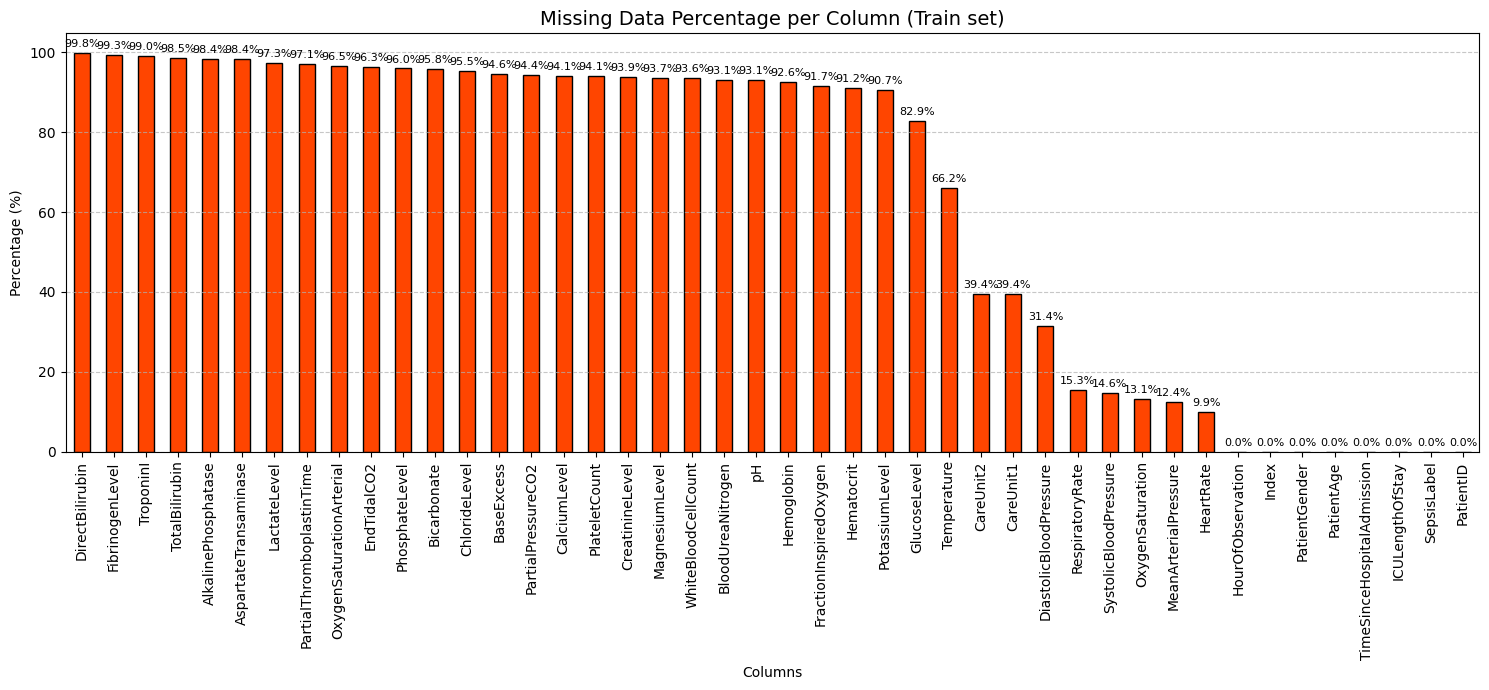

Column                         Missing (%)
------------------------------------------
DirectBilirubin                      99.8
FibrinogenLevel                      99.3
TroponinI                            99.0
TotalBilirubin                       98.5
AlkalinePhosphatase                  98.4
AspartateTransaminase                98.4
LactateLevel                         97.3
PartialThromboplastinTime            97.1
OxygenSaturationArterial             96.5
EndTidalCO2                          96.3
PhosphateLevel                       96.0
Bicarbonate                          95.8
ChlorideLevel                        95.5
BaseExcess                           94.6
PartialPressureCO2                   94.4
CalciumLevel                         94.1
PlateletCount                        94.1
CreatinineLevel                      93.9
MagnesiumLevel                       93.7
WhiteBloodCellCount                  93.6
BloodUreaNitrogen                    93.1
pH                              

In [ ]:
missing_counts = df.isna().sum()
missing_percent = round(100 * (missing_counts / len(df.index)), 2)
missing_sorted = missing_percent.sort_values(ascending=False)

plt.figure(figsize=(15, 7))
ax = missing_sorted.plot.bar(color='orangered', edgecolor='black')

for bar, percent in zip(ax.patches, missing_sorted):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1,
            f'{percent:.1f}%', ha='center', va='bottom', fontsize=8)

plt.title("Missing Data Percentage per Column (Train set)", fontsize=14)
plt.ylabel("Percentage (%)")
plt.xlabel("Columns")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

missing_data = missing_sorted[missing_percent > 0].sort_values(ascending=False)

print(f"{'Column':<30} {'Missing (%)':>10}")
print("-" * 42)

for col, percent in missing_data.items():
    print(f"{col:<30} {percent:>10.1f}")

Due to the ammount of null values, we have to impute first before continue EDA.

#Preprocessing: Delete Duplicates and Outliers Then Impute

We first removed duplicates and outliers to clean the data, resulting in better quality of data for the imputation step.

In [ ]:
# Cek jumlah baris sebelum
print(f"Jumlah baris sebelum drop duplikat: {df.shape[0]}")

# Drop baris yang semua kolomnya sama
df2 = df.drop_duplicates(subset=['PatientID', 'HourOfObservation'])
df3 = df.drop_duplicates(subset=['PatientID', 'SepsisLabel', 'HourOfObservation'])

# Cek jumlah baris setelah
print(f"Jumlah baris setelah drop duplikat: {df2.shape[0]}")
print(f"Jumlah baris setelah drop duplikat: {df3.shape[0]}")

Jumlah baris sebelum drop duplikat: 1552210
Jumlah baris setelah drop duplikat: 1552210
Jumlah baris setelah drop duplikat: 1552210


This technique uses the boxplot range, spanning from the first quartile (Q1) to the third quartile (Q3), with the line inside the box representing the median (Q2), while excluding demographic columns beforehand to ensure only clinical variables were affected.

In [ ]:
iqr_columns = ['HeartRate', 'OxygenSaturation', 'Temperature',
      'SystolicBloodPressure', 'MeanArterialPressure',
      'DiastolicBloodPressure', 'RespiratoryRate', 'EndTidalCO2',
      'BaseExcess', 'Bicarbonate', 'FractionInspiredOxygen', 'pH',
      'PartialPressureCO2', 'OxygenSaturationArterial',
      'AspartateTransaminase', 'BloodUreaNitrogen', 'AlkalinePhosphatase',
      'CalciumLevel', 'ChlorideLevel', 'CreatinineLevel', 'DirectBilirubin',
      'GlucoseLevel', 'LactateLevel', 'MagnesiumLevel', 'PhosphateLevel',
      'PotassiumLevel', 'TotalBilirubin', 'TroponinI', 'Hematocrit',
      'Hemoglobin', 'PartialThromboplastinTime', 'WhiteBloodCellCount',
      'FibrinogenLevel', 'PlateletCount']
      #Excluding Index, HourOfObservation, PatientAge, PatientGender, CareUnit1, CareUnit2, TimeSinceHospitalAdmission, ICULengthOfStay (Demographics columns)

> These boxplots show the columns we used to remove outliers. The lines outside the box are called whiskers, showing the lowest and highest values still considered normal. Any circled points that fall outside those lines are the outliers.

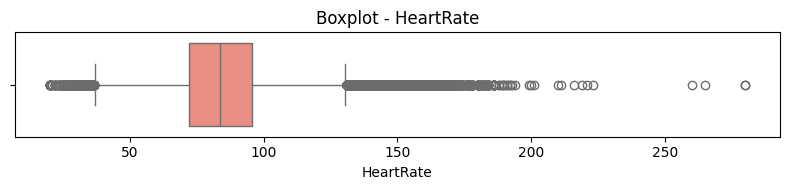

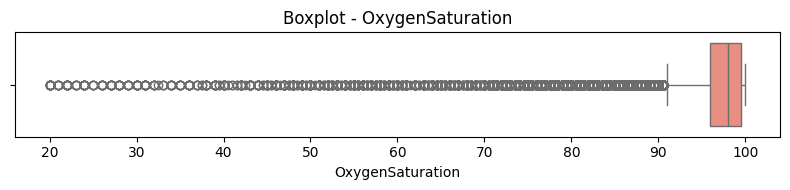

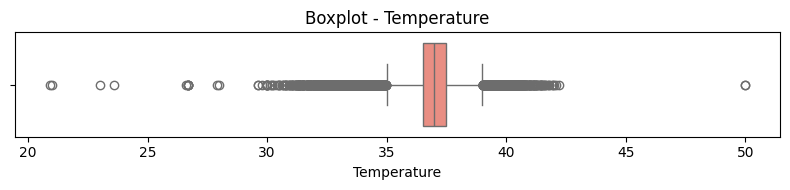

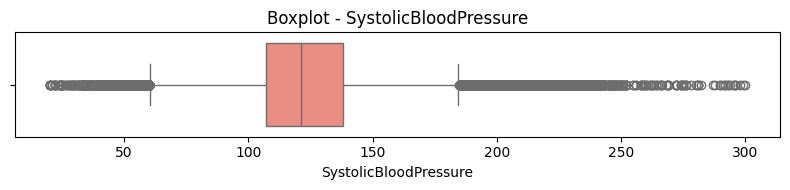

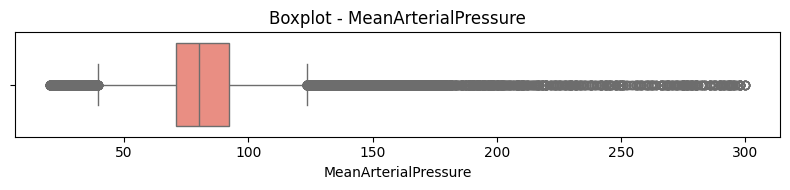

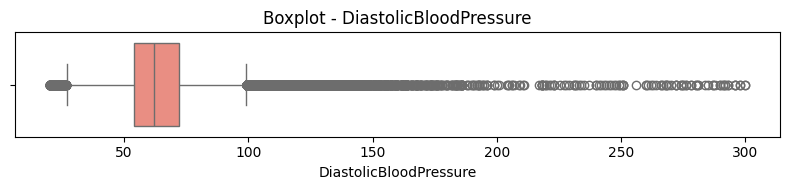

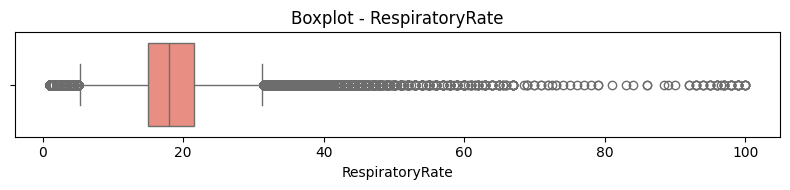

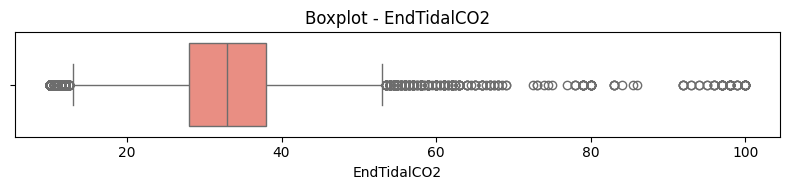

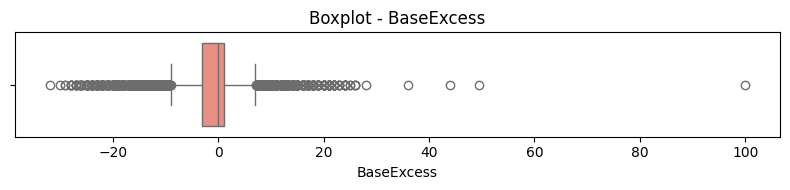

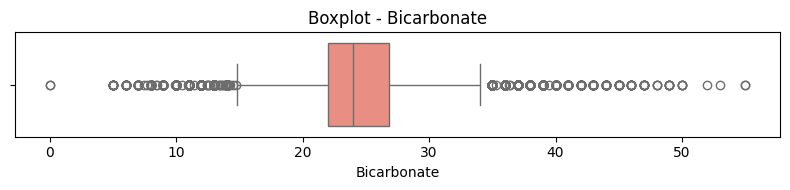

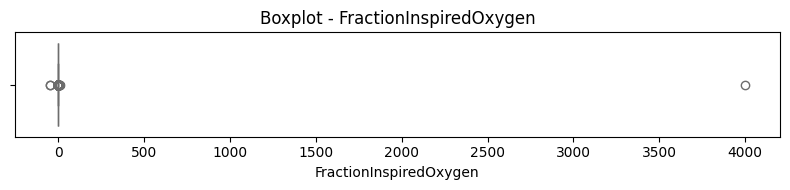

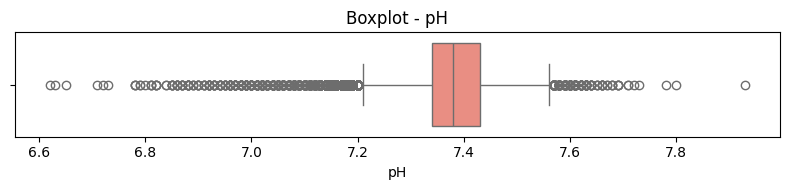

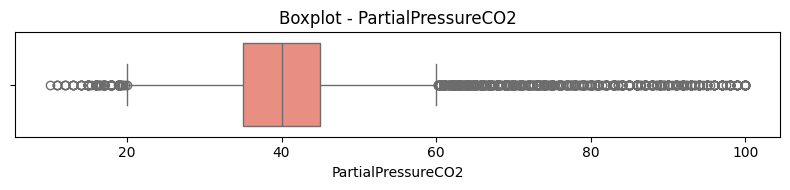

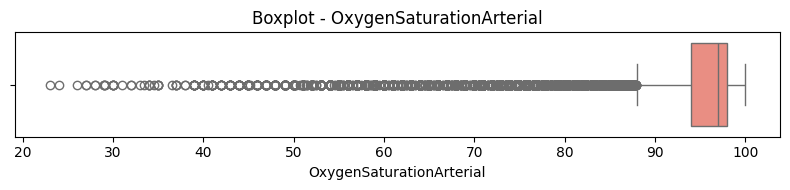

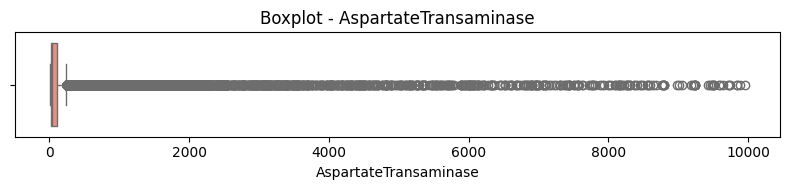

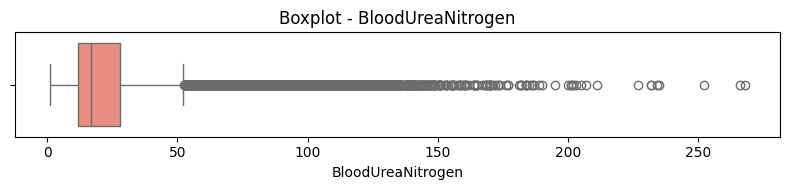

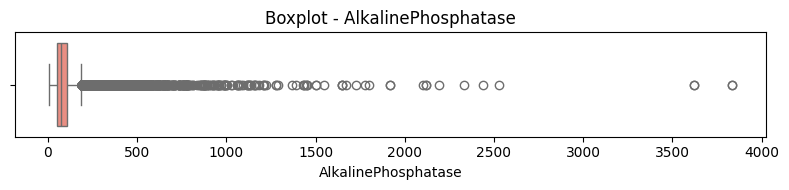

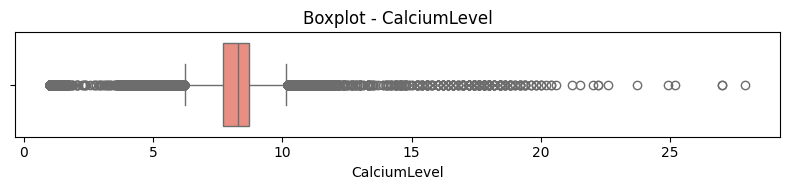

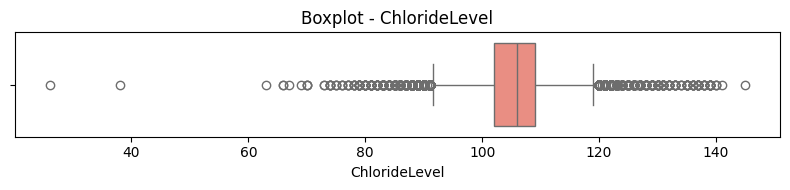

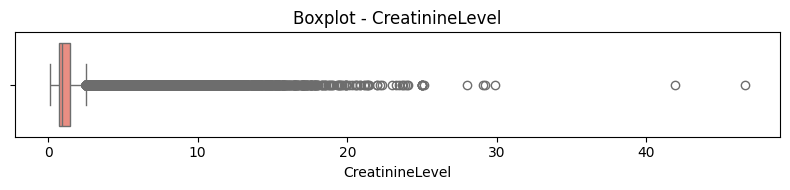

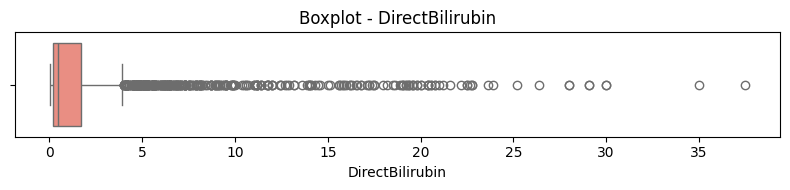

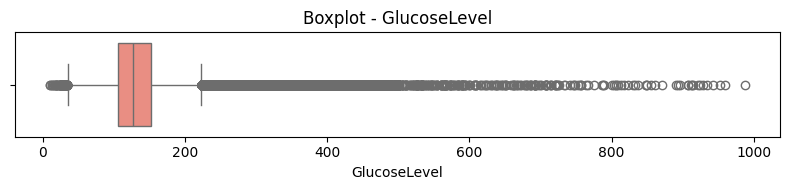

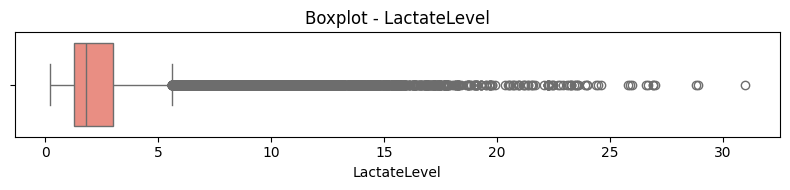

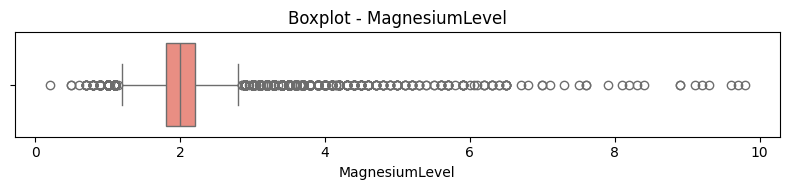

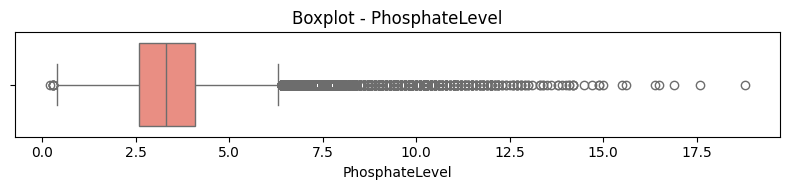

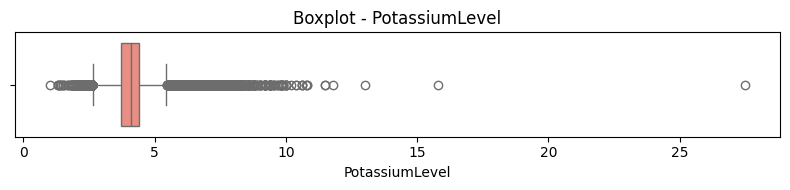

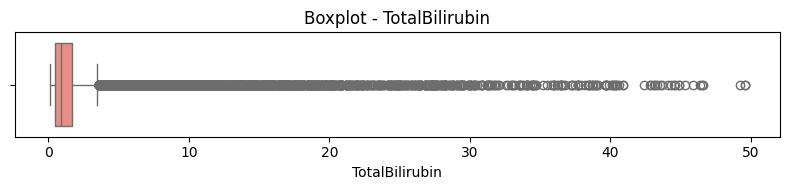

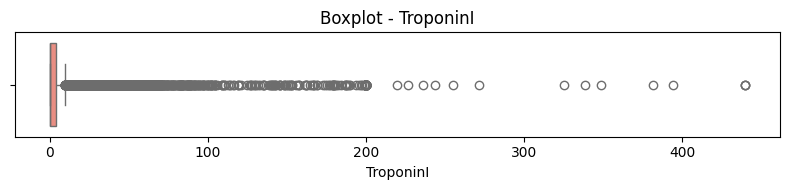

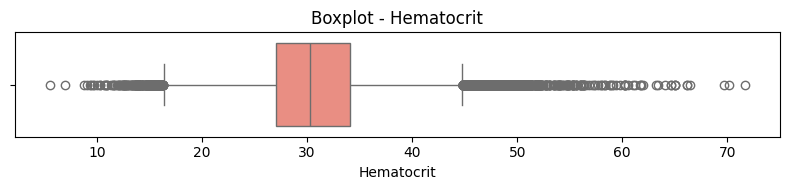

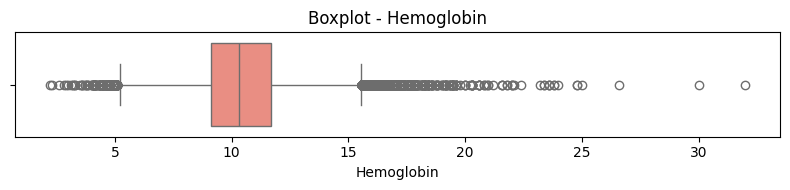

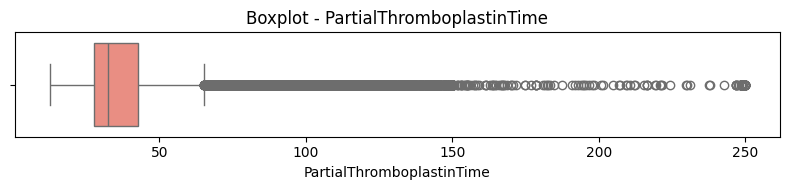

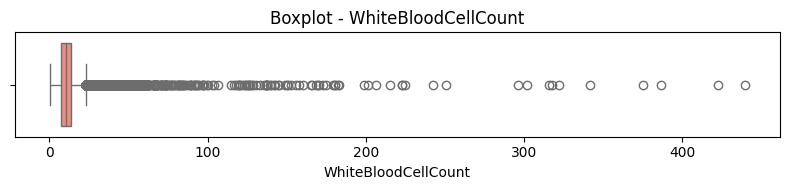

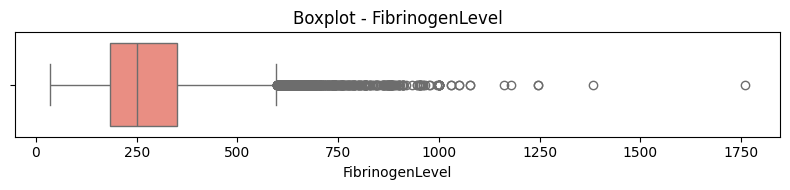

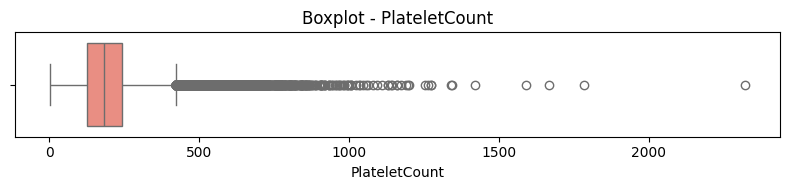

In [ ]:
#boxplot for detecting outliers
for col in iqr_columns:
    if df[col].dropna().empty:
        print(f"Skipping {col} (all NaN)")
        continue

    plt.figure(figsize=(8, 2))
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f'Boxplot - {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

> As mentioned, a boxplot shows the range between the first (Q1) and third quartile (Q3), where most data points lie. The whiskers extend to the acceptable range, and values outside this range are considered outliers and removed. Below are the boxplots and actual distributions of the 'OxygenSaturation' and 'LactateLevel' variables. As you can see, the boxplot stand in where most data points lie.


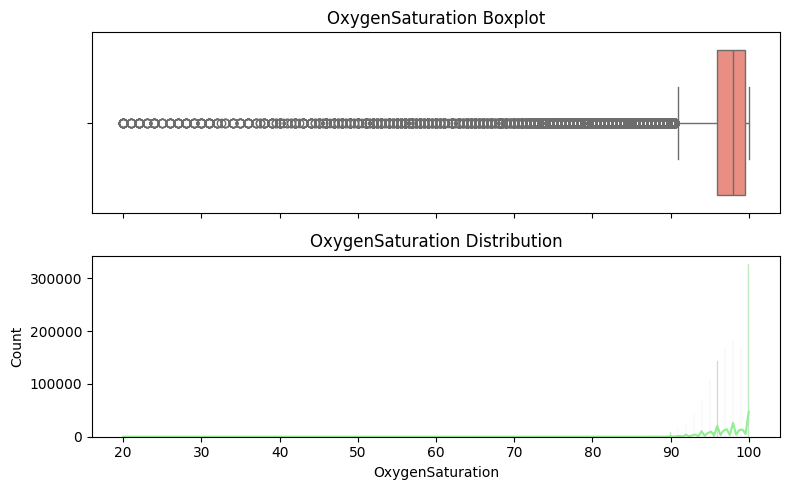

In [ ]:
col = 'OxygenSaturation'

fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

sns.boxplot(x=df[col], ax=axes[0], color='salmon')
sns.histplot(df[col], kde=True, ax=axes[1], color='lightgreen', edgecolor='black')

axes[0].set(title=f'{col} Boxplot')
axes[1].set(title=f'{col} Distribution', ylabel='Count')

plt.tight_layout()
plt.show()

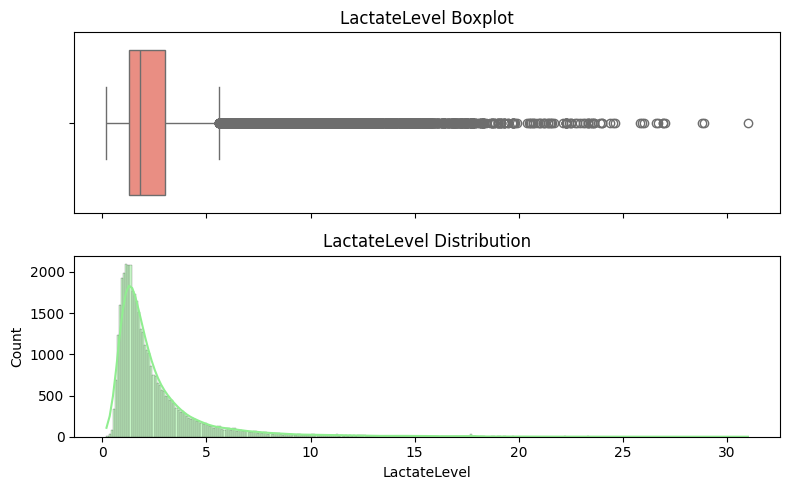

In [ ]:
col = 'LactateLevel'

fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

sns.boxplot(x=df[col], ax=axes[0], color='salmon')
sns.histplot(df[col], kde=True, ax=axes[1], color='lightgreen', edgecolor='black')

axes[0].set(title=f'{col} Boxplot')
axes[1].set(title=f'{col} Distribution', ylabel='Count')

plt.tight_layout()
plt.show()



> Performing IQR filtering



In [ ]:
print("Remaining rows before IQR filtering:", len(df))

df_iqr = df.copy()
for col in iqr_columns:
    if col in df_iqr.columns:
        Q1 = df_iqr[col].quantile(0.25)
        Q3 = df_iqr[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_iqr = df_iqr[(df_iqr[col].isnull()) | ((df_iqr[col] >= lower_bound) & (df_iqr[col] <= upper_bound))]

print("Remaining rows after IQR filtering:", len(df_iqr))

Remaining rows before IQR filtering: 1552210
Remaining rows after IQR filtering: 1344616


> Performing imputation

We used forward fill (ffill) and backward fill (bfill) imputation, which to supports our assumption that the missing values are normal occurrences—likely caused by limited hospital resources.

Forward fill replaces missing values by carrying the last known value forward, while backward fill does the opposite by filling missing entries with the next available value. This works well in patient data where values are recorded over time. Then, to explain ffill and bfill better, we will show you an images example below.

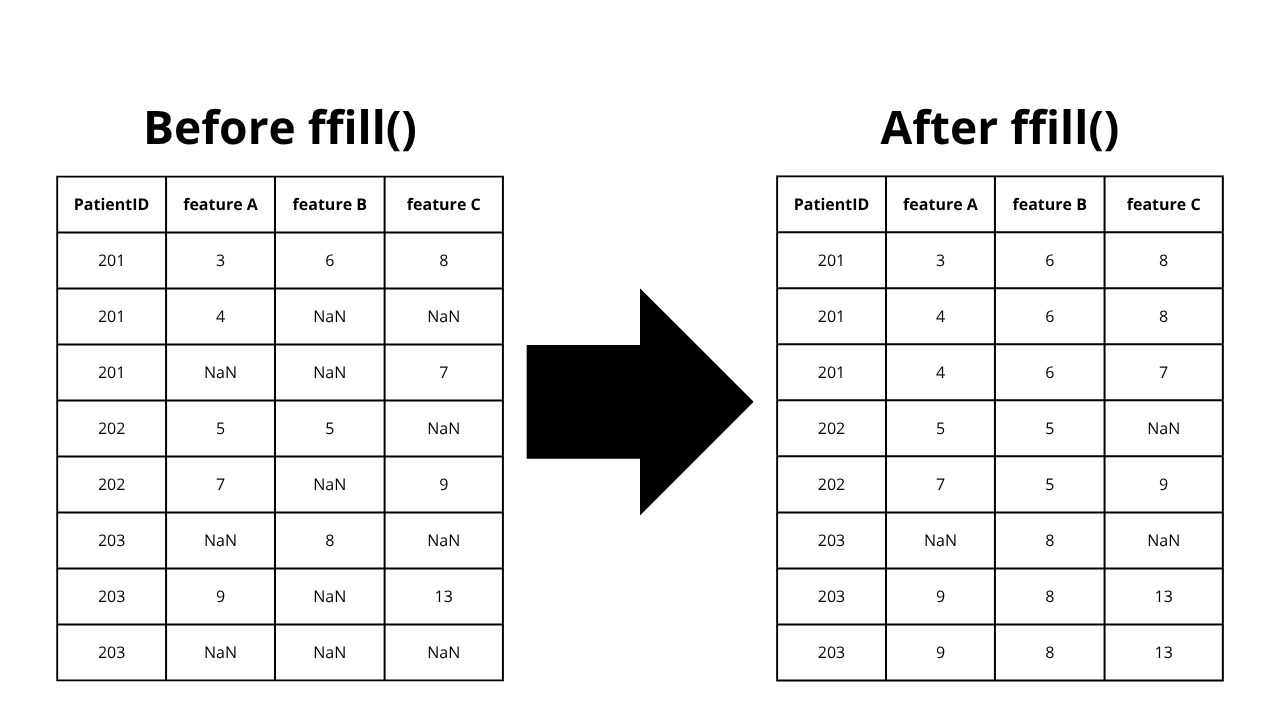

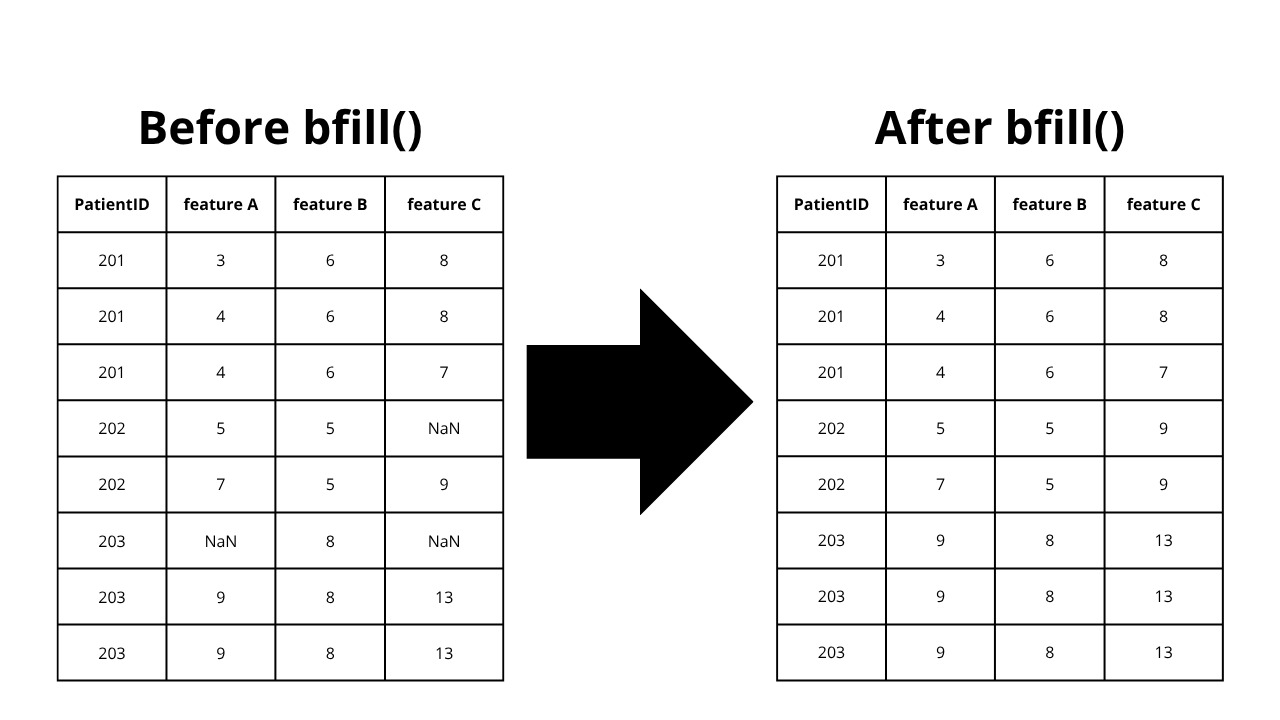

In [ ]:
#ffill and bfill
cols_with_nan = df_iqr.columns[df.isnull().any()].tolist()

df_imputed = df_iqr.copy()
df_imputed[cols_with_nan] = (
    df_imputed.groupby('PatientID')[cols_with_nan].ffill().bfill()
)

In [ ]:
df_imputed.columns

Index(['Index', 'HourOfObservation', 'HeartRate', 'OxygenSaturation',
       'Temperature', 'SystolicBloodPressure', 'MeanArterialPressure',
       'DiastolicBloodPressure', 'RespiratoryRate', 'EndTidalCO2',
       'BaseExcess', 'Bicarbonate', 'FractionInspiredOxygen', 'pH',
       'PartialPressureCO2', 'OxygenSaturationArterial',
       'AspartateTransaminase', 'BloodUreaNitrogen', 'AlkalinePhosphatase',
       'CalciumLevel', 'ChlorideLevel', 'CreatinineLevel', 'DirectBilirubin',
       'GlucoseLevel', 'LactateLevel', 'MagnesiumLevel', 'PhosphateLevel',
       'PotassiumLevel', 'TotalBilirubin', 'TroponinI', 'Hematocrit',
       'Hemoglobin', 'PartialThromboplastinTime', 'WhiteBloodCellCount',
       'FibrinogenLevel', 'PlateletCount', 'PatientAge', 'PatientGender',
       'CareUnit1', 'CareUnit2', 'TimeSinceHospitalAdmission',
       'ICULengthOfStay', 'SepsisLabel', 'PatientID'],
      dtype='object')

In [ ]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1344616 entries, 0 to 1552209
Data columns (total 44 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Index                       1344616 non-null  int64  
 1   HourOfObservation           1344616 non-null  int64  
 2   HeartRate                   1344616 non-null  float64
 3   OxygenSaturation            1344616 non-null  float64
 4   Temperature                 1344616 non-null  float64
 5   SystolicBloodPressure       1344616 non-null  float64
 6   MeanArterialPressure        1344616 non-null  float64
 7   DiastolicBloodPressure      1344616 non-null  float64
 8   RespiratoryRate             1344616 non-null  float64
 9   EndTidalCO2                 1344503 non-null  float64
 10  BaseExcess                  1342529 non-null  float64
 11  Bicarbonate                 1342529 non-null  float64
 12  FractionInspiredOxygen      1344482 non-null  float64
 13  pH

> After applying ffill and bfill, the percentage of missing values dropped to below 0.5%. This significant reduction supports our assumption that most missing values were not due to data errors, but rather because certain variables were not measured at every time step—likely a result of hospital resource limitations.

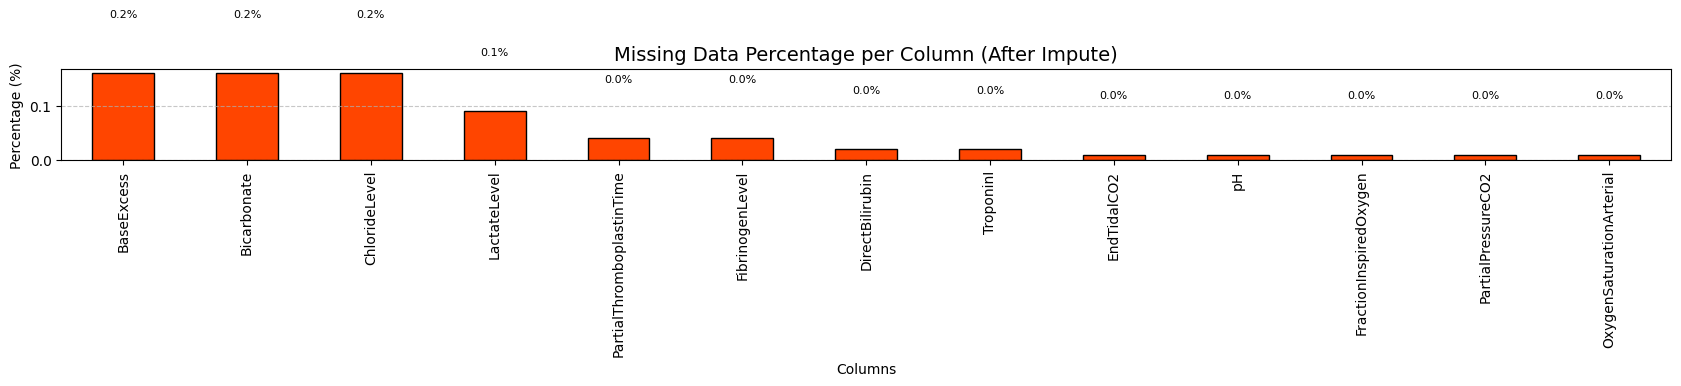

Column                         Missing (%)
------------------------------------------
BaseExcess                            0.2
Bicarbonate                           0.2
ChlorideLevel                         0.2
LactateLevel                          0.1
PartialThromboplastinTime             0.0
FibrinogenLevel                       0.0
DirectBilirubin                       0.0
TroponinI                             0.0
EndTidalCO2                           0.0
pH                                    0.0
FractionInspiredOxygen                0.0
PartialPressureCO2                    0.0
OxygenSaturationArterial              0.0


In [ ]:
# Calculate missing percentage
missing_counts = df_imputed.isna().sum()
missing_percent = round(100 * (missing_counts / len(df_imputed.index)), 2)

# Sort by descending percentage
missing_sorted = missing_percent[missing_percent > 0].sort_values(ascending=False)

# Plot
plt.figure(figsize=(17, 6))
ax = missing_sorted.plot.bar(color='orangered', edgecolor='black')

# Add text labels above bars
for bar, percent in zip(ax.patches, missing_sorted):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.1,  # just a bit above bar
        f'{percent:.1f}%',
        ha='center',
        va='bottom',
        fontsize=8
    )

# Aesthetics
plt.title("Missing Data Percentage per Column (After Impute)", fontsize=14)
plt.ylabel("Percentage (%)")
plt.xlabel("Columns")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print table
print(f"{'Column':<30} {'Missing (%)':>10}")
print("-" * 42)
for col, percent in missing_sorted.items():
    print(f"{col:<30} {percent:>10.1f}")


> Drop the Rest NULL Values

Lastly, the remaining missing values—which couldn’t be filled due to the absence of any available data (meaning these variables were likely never measured for the patient)—were removed, as they made up only a very small portion of the dataset.

In [ ]:
print("Test  sebelum:", df_imputed.shape)

df_imputed.dropna(inplace=True)

print("Test  sesudah:", df_imputed.shape)

Test  sebelum: (1344616, 44)
Test  sesudah: (1342529, 44)


# (Experiment) Train with vital signs only

> In this part, we test how well the model performs using only vital signs. These include basic health measurements like heart rate, breathing rate, blood pressure, temperature, and oxygen level. The goal is to see if the model can still predict sepsis accurately without using lab results data.

In [ ]:
vital_signs = ['HeartRate', 'OxygenSaturation', 'Temperature',
      'SystolicBloodPressure', 'MeanArterialPressure',
      'DiastolicBloodPressure', 'RespiratoryRate', 'EndTidalCO2']

df_vital = df_imputed[vital_signs + ['SepsisLabel']]

In [ ]:
from sklearn.model_selection import train_test_split

X = df_vital[vital_signs]
y = df_vital['SepsisLabel']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# loaded_model = joblib.load('Random Forest (Vital Signs Only).joblib')
# model = loaded_model

RandomForestClassifier(random_state=42)

Confusion Matrix:


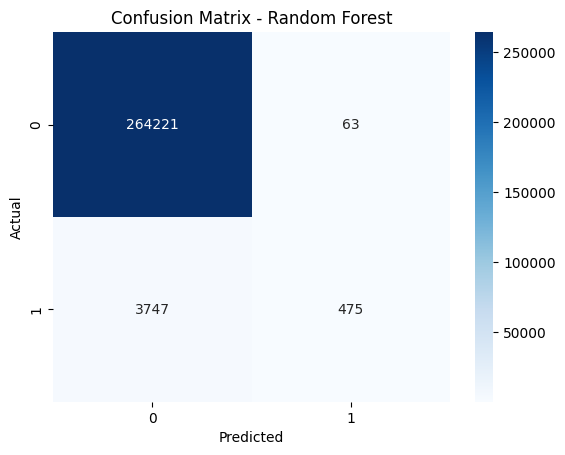

              precision    recall  f1-score   support

           0      0.986     1.000     0.993    264284
           1      0.883     0.113     0.200      4222

    accuracy                          0.986    268506
   macro avg      0.934     0.556     0.596    268506
weighted avg      0.984     0.986     0.980    268506

ROC AUC: 0.7874


In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

print(classification_report(y_test, y_pred, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

> Even though the model has high accuracy, it's not really good at finding patients who actually have sepsis. The recall and f1 score for positive sepsis cases is very low, which means the model often says an (actual positive) patient doesn’t have sepsis (predicted negative) even when they do.

>So since the model is still imbalance towards the negative output, we still need more impormation to balance things up, meaning we still need other features.

# EDA (After Impute)



> Now that the dataset has been fully imputed, we can move on to visualizing the feature distributions and training the model. Below are the distribution plots for each feature.

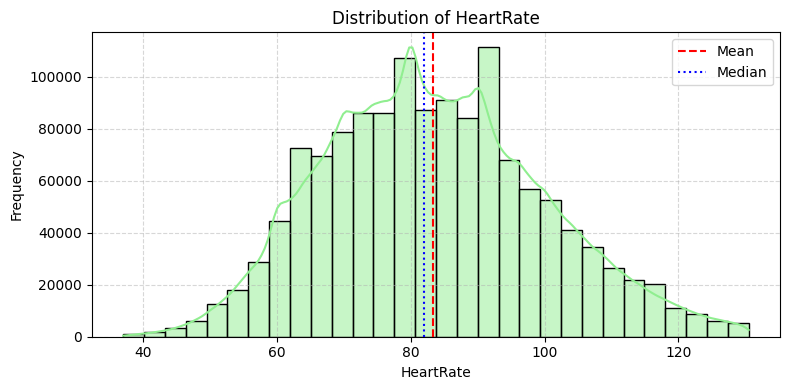

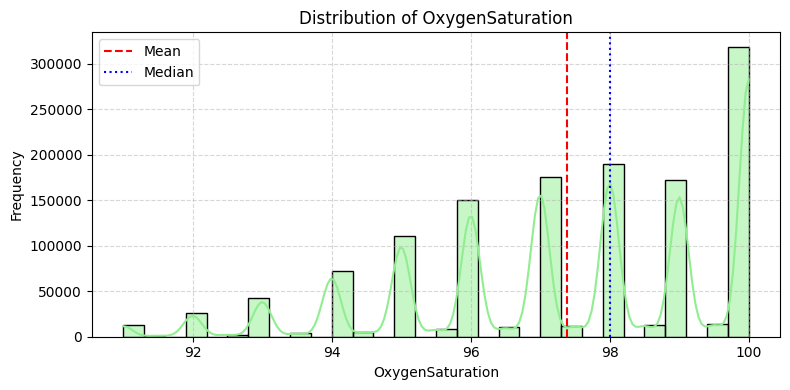

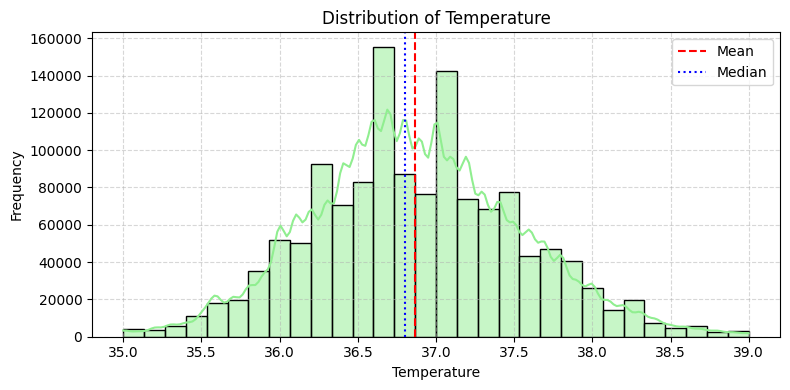

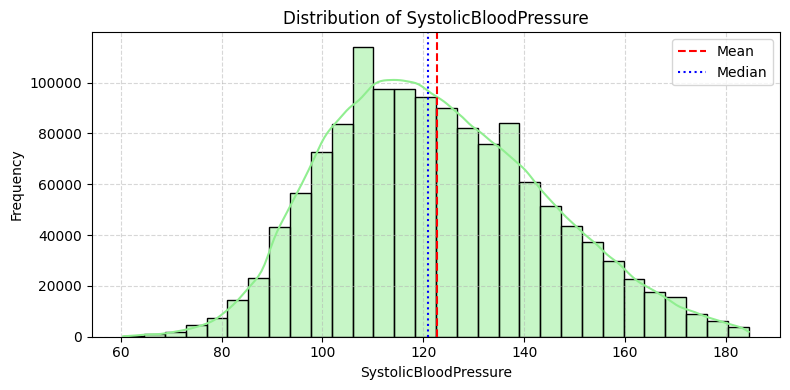

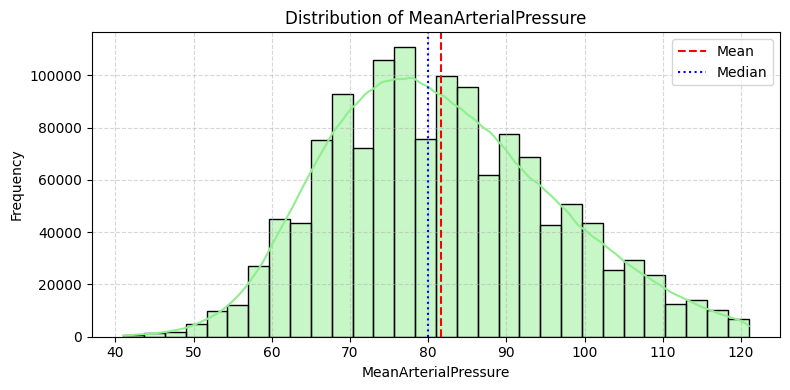

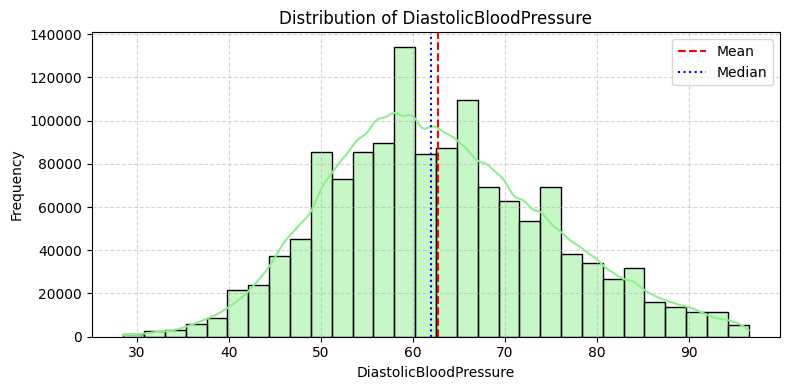

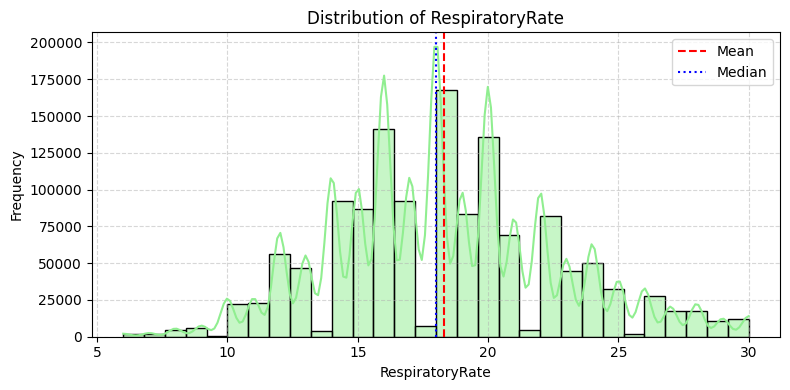

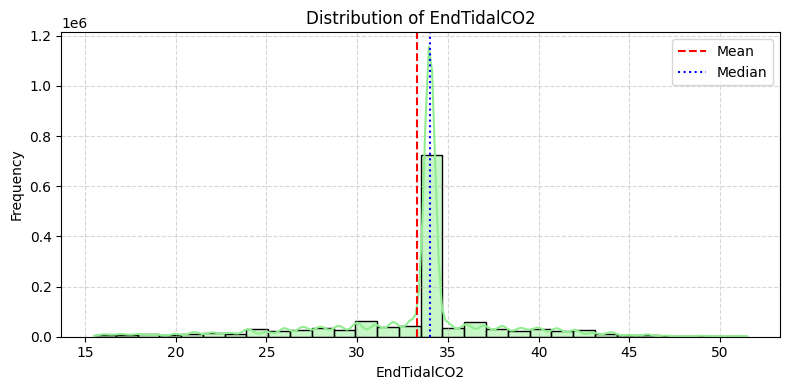

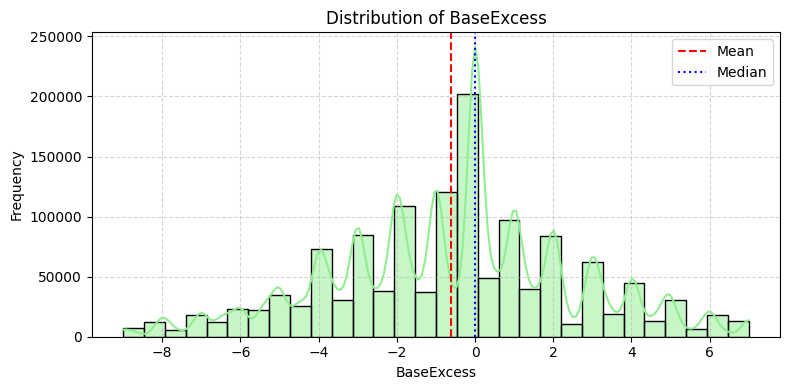

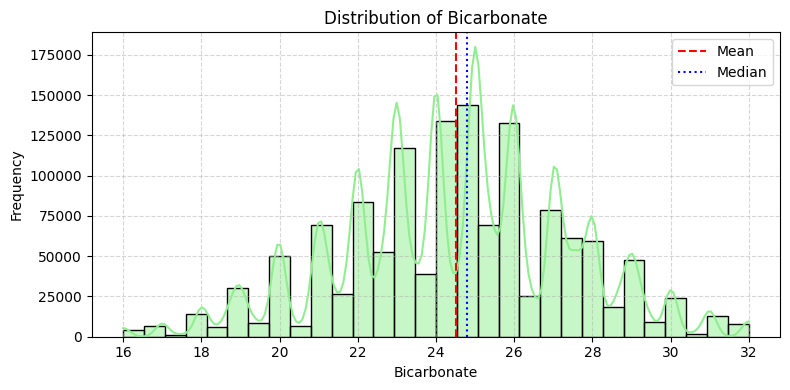

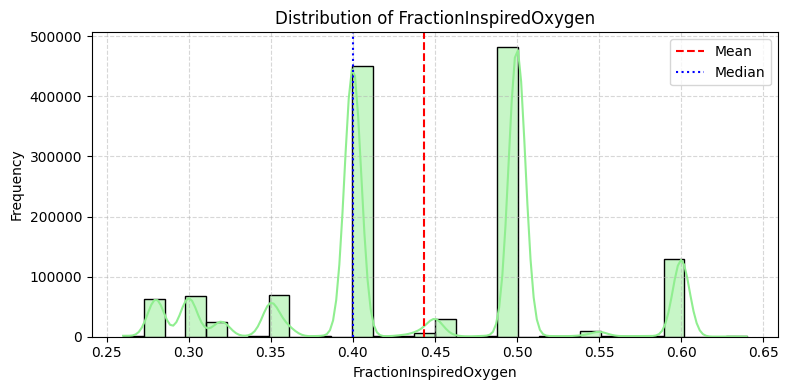

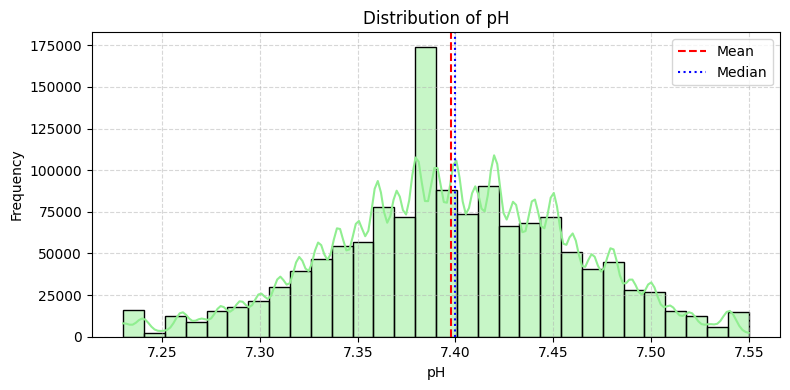

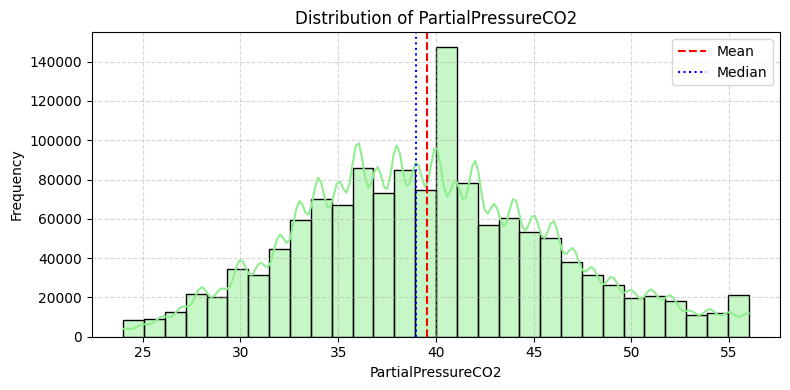

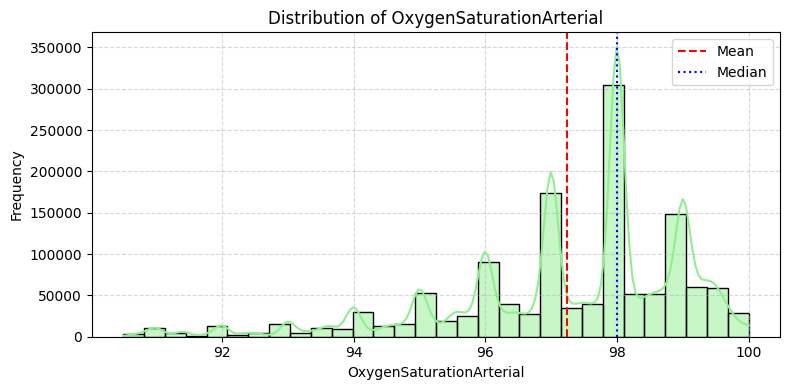

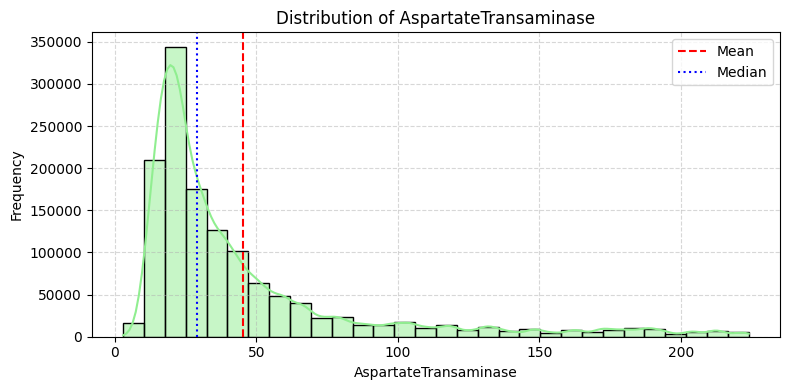

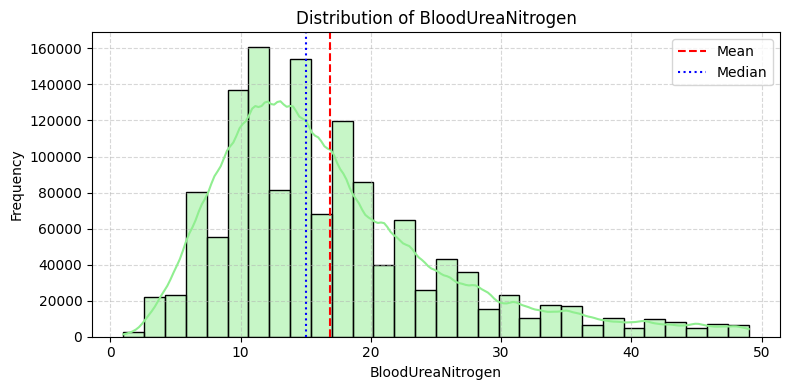

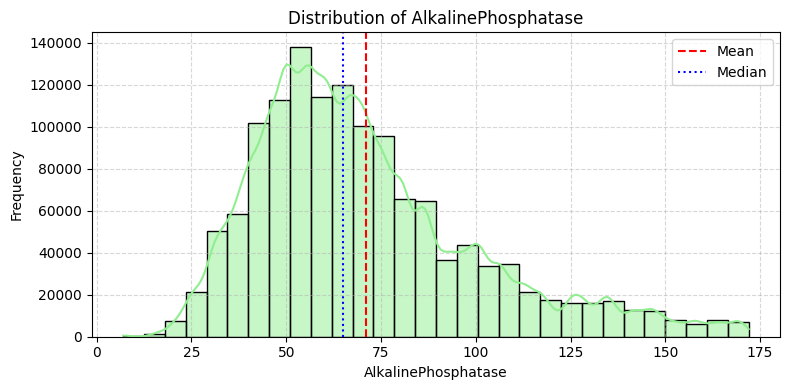

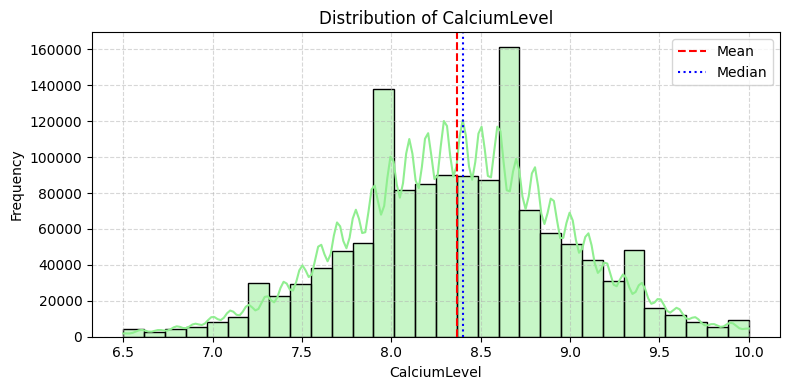

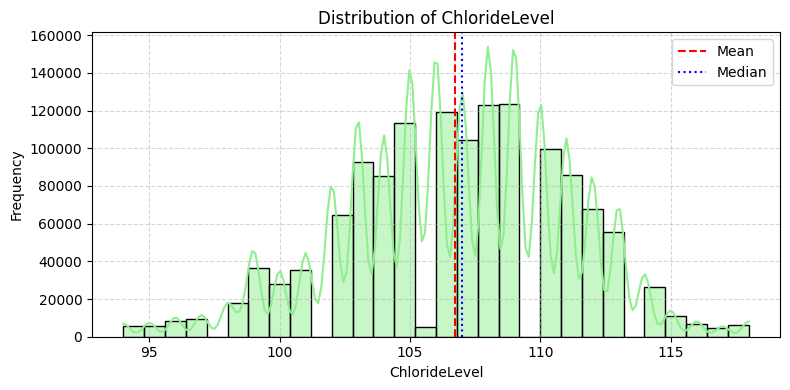

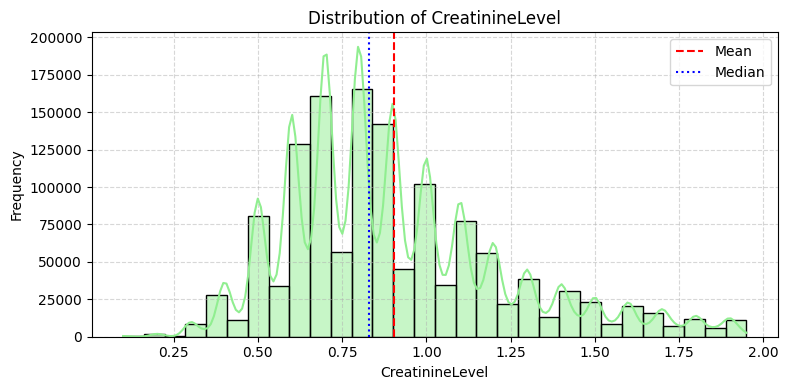

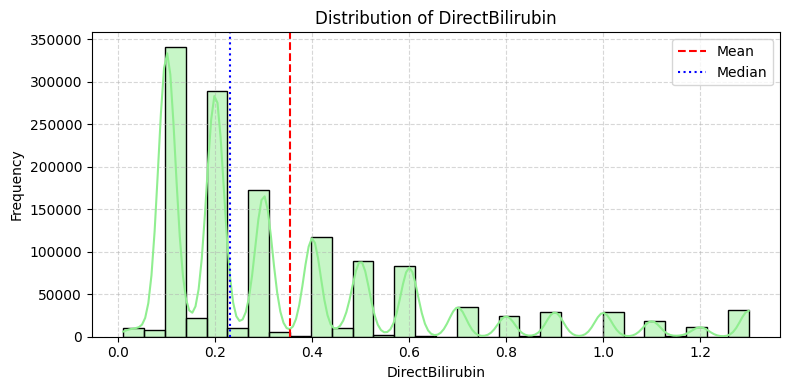

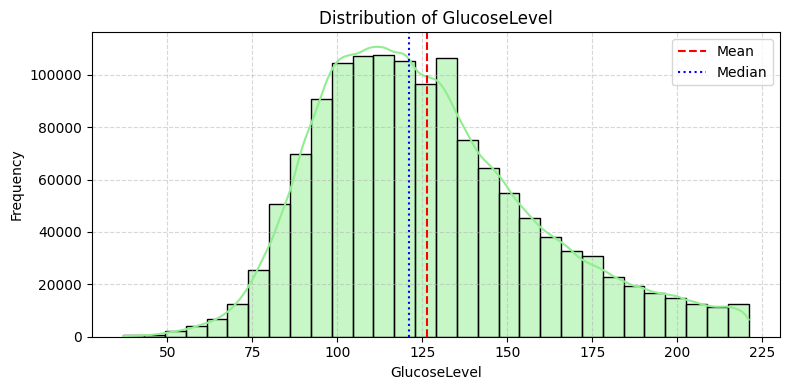

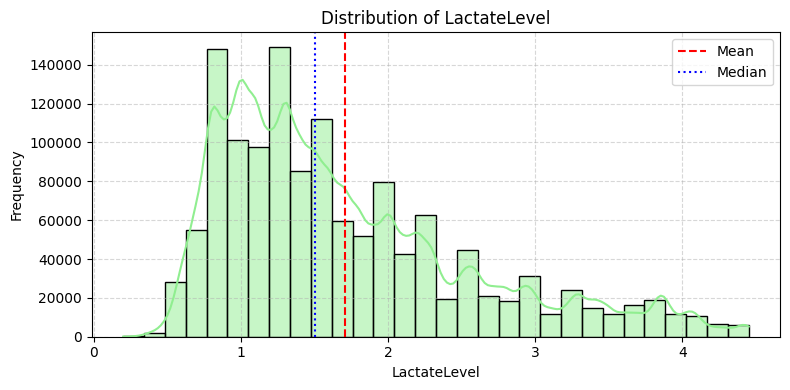

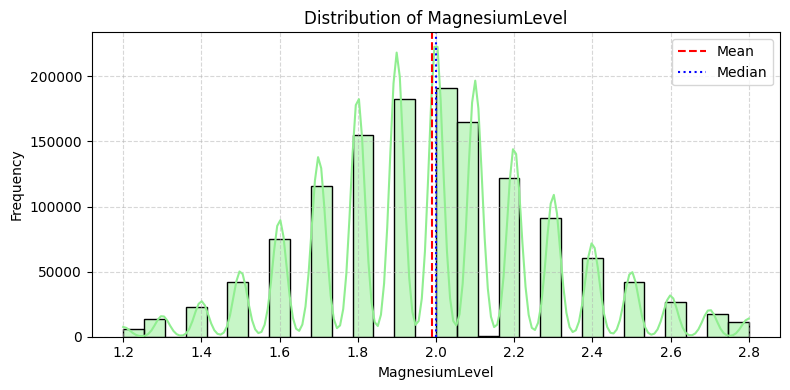

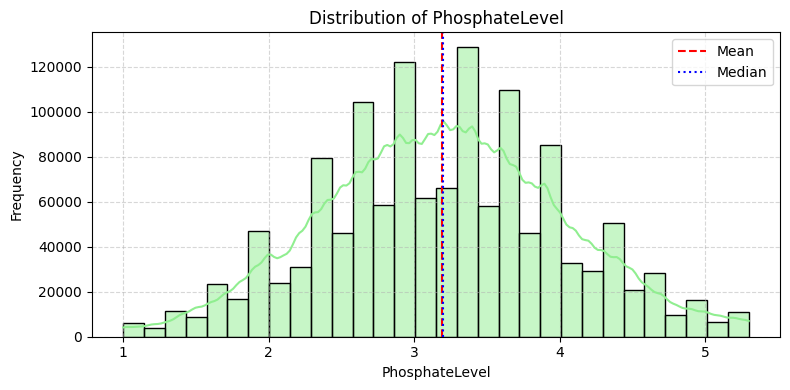

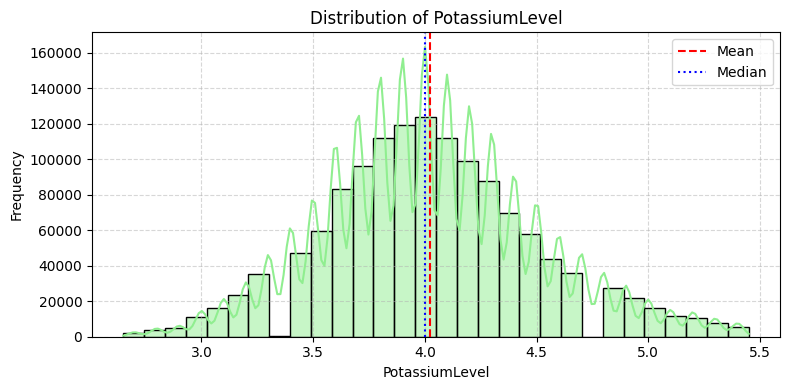

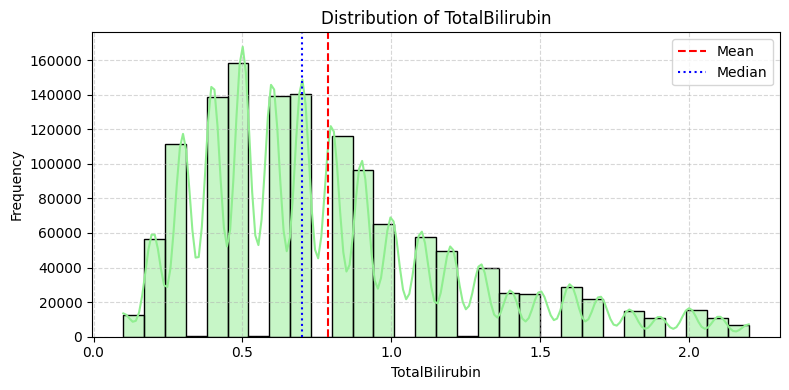

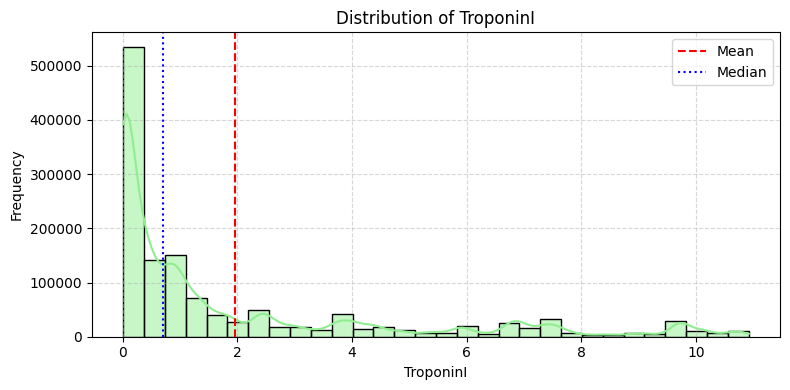

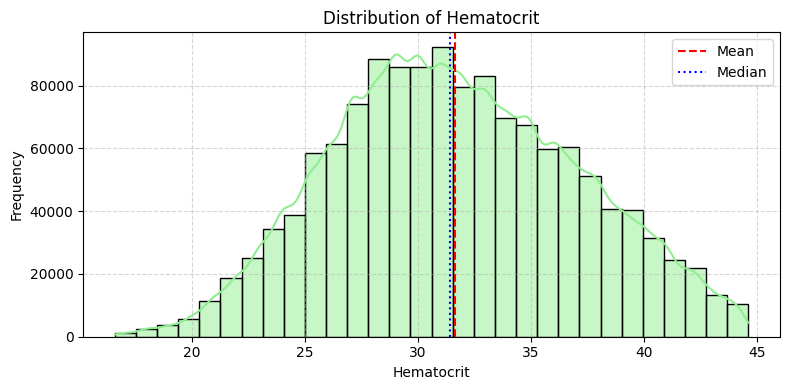

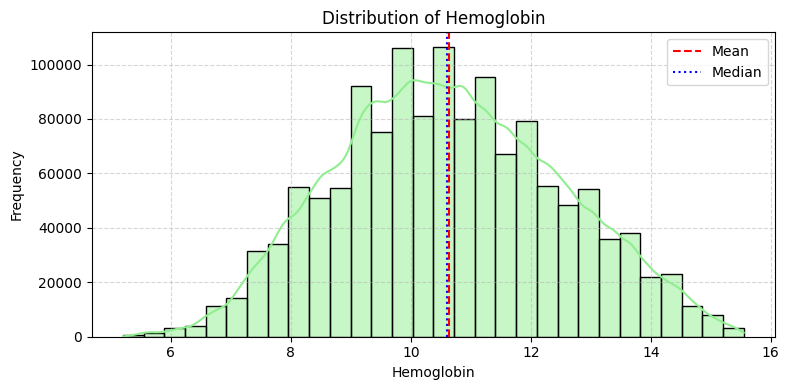

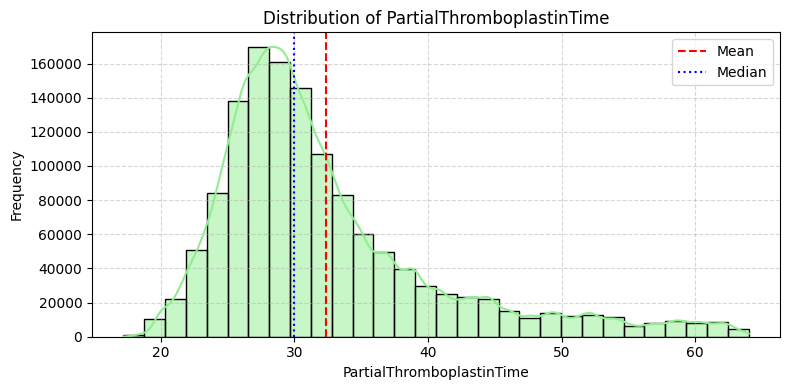

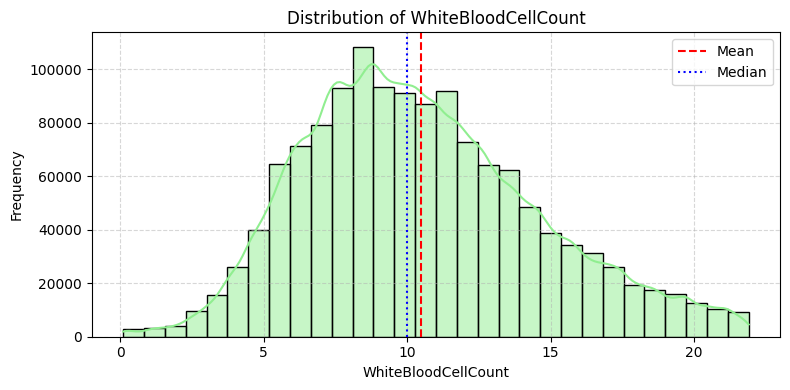

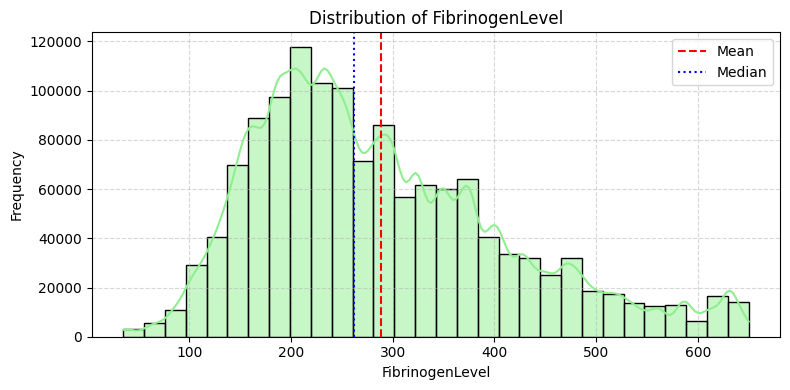

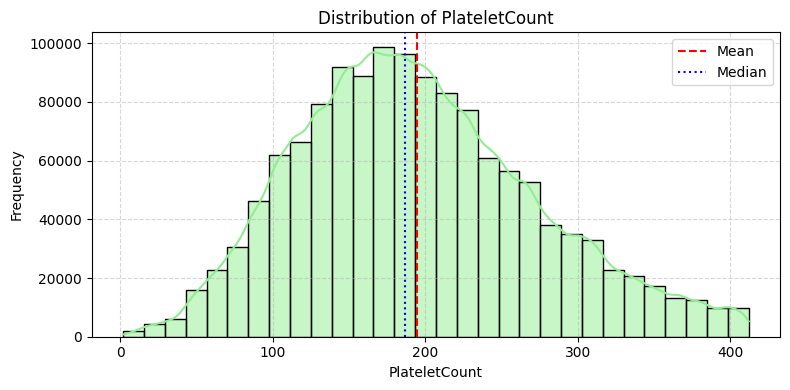

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in iqr_columns:
    plt.figure(figsize=(8, 4))

    if df_imputed[col].nunique() < 15:
        sns.countplot(x=col, data=df_imputed, color='lightgreen', edgecolor='black')
    else:
        sns.histplot(df_imputed[col], bins=30, kde=True, color='lightgreen', edgecolor='black')
        plt.axvline(df_imputed[col].mean(), color='red', linestyle='--', label='Mean')
        plt.axvline(df_imputed[col].median(), color='blue', linestyle=':', label='Median')
        plt.legend()

    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


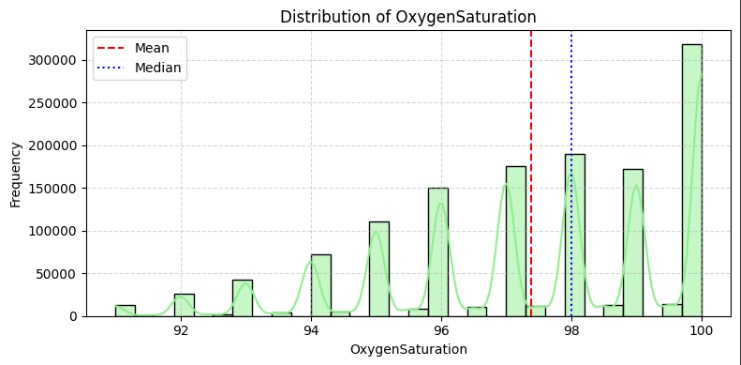

> Please look at the distribution above. Even though it may looks complex, it is actually the matter of distribution range. The distribution in controlled range should be looking like this:

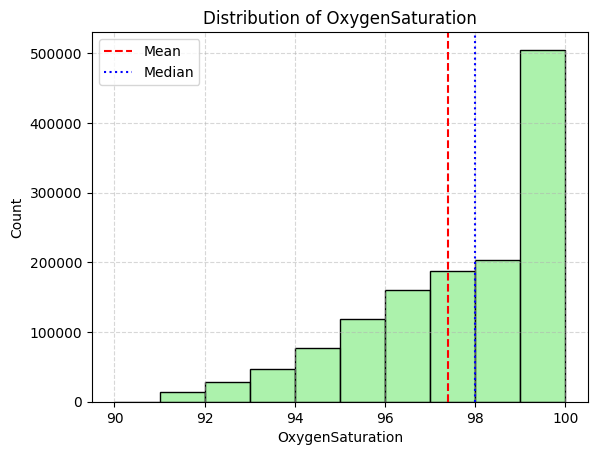

In [ ]:
col = 'OxygenSaturation'

sns.histplot(df_imputed[col], bins=range(90, 101), color='lightgreen', edgecolor='black')

# Add mean and median lines
plt.axvline(df_imputed[col].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(df_imputed[col].median(), color='blue', linestyle=':', label='Median')

# Add title, labels, legend
plt.title(f'Distribution of {col}')
plt.xlabel(col)
plt.ylabel('Count')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

Since both outliers and missing values have been properly handled, the resulting data is now clean and ready for model training.

# Feature Engineering - Feature Selection for Deleting Multicollinearity and Dimensionality Reduction



However, to further improve model performance and reduce complexity, we apply feature engineering.

This include;

1.   Selecting the most relevant features (Goal Based correlation),
2.   Removing multicollinearity(Pair Wised Correlation and VIF),
3.   performing dimensionality reduction (PCA) while preserving most of the data’s variance.


In [ ]:
temp = df_imputed.drop(columns=['PatientID', 'Index', 'SepsisLabel'])



> Feature Selection - Pair Wise Correlation

Pairwise correlation means checking how closely two features are related to each other.
If two features are very similar, we might remove one to avoid confusing the model.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


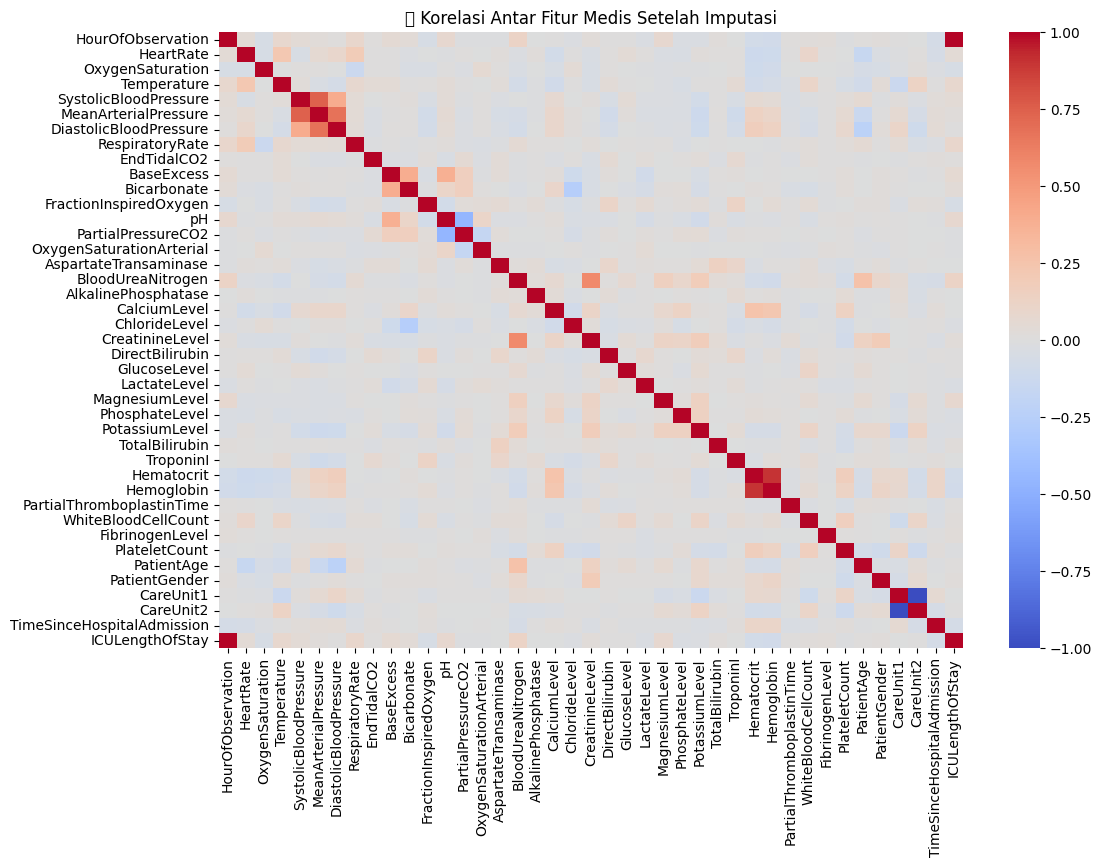

In [ ]:
plt.figure(figsize=(12, 8))
corr = temp.corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("🔍 Korelasi Antar Fitur Medis Setelah Imputasi")
plt.show()

In [ ]:
corr_matrix = temp.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.9

high_corr_pairs = (
    upper.stack()
    .reset_index()
    .rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation"})
    .query("Correlation > @threshold")
    .sort_values(by="Correlation", ascending=False)
)

print("Pair of features with high correlation (> 0.9):")
print(high_corr_pairs)

Pair of features with high correlation (> 0.9):
             Feature 1        Feature 2  Correlation
814          CareUnit1        CareUnit2     1.000000
39   HourOfObservation  ICULengthOfStay     0.994759
754         Hematocrit       Hemoglobin     0.902090


In [ ]:
drop_cols = ['CareUnit2', 'ICULengthOfStay', 'Hematocrit'] #Hematocrit is deleted because Hemoglobin is more commonly checked.

df_FS = df_imputed.drop(columns=drop_cols + ["Index", "PatientID"])
temp = temp.drop(columns=drop_cols)

> Feature Selection-Target Based Correlation

Target-based correlation means checking how strongly each feature is related to the target (like “SepsisLabel”).

We use this to choose the features that are most helpful for predicting the outcome.

In [ ]:
# Value Correlation
value_corrs = {}
for col in df_DR.columns:
    if col == 'SepsisLabel':
        continue
    valid_rows = df_DR[[col, 'SepsisLabel']].dropna()
    if not valid_rows.empty:
        corr_value = valid_rows[col].corr(valid_rows['SepsisLabel'])
        value_corrs[col] = corr_value
value_corrs = pd.Series(value_corrs)
value_corrs = value_corrs.sort_values(ascending=False)

print(value_corrs)

HourOfObservation             0.130411
Temperature                   0.048284
HeartRate                     0.040220
RespiratoryRate               0.032004
BloodUreaNitrogen             0.025571
WhiteBloodCellCount           0.015358
CareUnit1                     0.012640
BaseExcess                    0.012407
pH                            0.010006
TroponinI                     0.009491
PatientGender                 0.008360
MagnesiumLevel                0.007830
PartialThromboplastinTime     0.007285
FractionInspiredOxygen        0.006945
GlucoseLevel                  0.005913
TotalBilirubin                0.005801
DirectBilirubin               0.005267
AlkalinePhosphatase           0.004801
CreatinineLevel               0.004797
EndTidalCO2                   0.004553
AspartateTransaminase         0.004235
FibrinogenLevel               0.002576
ChlorideLevel                 0.002389
OxygenSaturationArterial      0.001887
PatientAge                    0.001377
OxygenSaturation         

Based on the biserial correlation analysis with SepsisLabel, HourOfObservation shows the highest positive correlation among all features. This result aligns well with clinical expectations, as sepsis often develops progressively over time during a patient’s hospital stay.

In a goal-based correlation analysis, especially when the target is binary, low absolute correlation values do not necessarily indicate that a feature is unimportant. Hence we should not delete any features based on their low correlation with Target.


> Feature Selection - VIF

Unlike pair wised correlation, VIF is stronger. VIF tells us if a feature can be predicted using multiple other features.

> If a feature has a high VIF, it means it’s too similar to a mix of other features and will be deleted to avoid confussion.


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import pandas as pd

temp_scaled = StandardScaler().fit_transform(temp)
temp_scaled_df = pd.DataFrame(temp_scaled, columns=temp.columns)

vif_data = pd.DataFrame()
vif_data['Feature'] = temp_scaled_df.columns
vif_data['VIF'] = [variance_inflation_factor(temp_scaled_df.values, i)
                   for i in range(temp_scaled_df.shape[1])]

vif_data = vif_data.sort_values('VIF', ascending=False)
print(vif_data)


                       Feature       VIF
5         MeanArterialPressure  3.832143
4        SystolicBloodPressure  2.558879
6       DiastolicBloodPressure  2.003068
12                          pH  1.769795
16           BloodUreaNitrogen  1.668704
20             CreatinineLevel  1.595655
9                   BaseExcess  1.590075
13          PartialPressureCO2  1.575886
10                 Bicarbonate  1.297619
34                  PatientAge  1.220483
1                    HeartRate  1.181652
29                  Hemoglobin  1.174189
18                CalciumLevel  1.154302
26              PotassiumLevel  1.138332
3                  Temperature  1.133195
33               PlateletCount  1.124378
31         WhiteBloodCellCount  1.118234
19               ChlorideLevel  1.107511
36                   CareUnit1  1.090277
35               PatientGender  1.087731
7              RespiratoryRate  1.078255
0            HourOfObservation  1.063880
25              PhosphateLevel  1.058414
24              

In this case, all features exhibit VIF values well below the common threshold of 5, indicating no significant multicollinearity within the dataset. So, there is no need to drop any feature solely based on VIF

> Dimensionality Reduction-PCA

So far, only pairwise correlation helped us reduce features. Now, we apply dimensionality reduction using the PCA algorithm, which reduces the number of features while still keeping 95% of the original data’s variance.

In [ ]:
from sklearn.decomposition import PCA

X_scaled = temp_scaled

pca = PCA(n_components=0.95, random_state=42) #Maintain 95% of data variances.
X_pca = pca.fit_transform(X_scaled)

print(f"Original shape: {X_scaled.shape}")
print(f"PCA-reduced shape: {X_pca.shape}")
print(f"Explained variance total: {pca.explained_variance_ratio_.sum():.2%}")

Original shape: (1342529, 38)
PCA-reduced shape: (1342529, 34)
Explained variance total: 96.48%


In [ ]:
# Columns before PCA
columns_before = temp.columns.tolist()

# Columns after PCA
columns_after = [f'PC{i+1}' for i in range(X_pca.shape[1])]

# Columns deleted (by position count)
columns_deleted = columns_before[len(columns_after):]

print("Columns before:", len(columns_before))
print("Columns after:", len(columns_after))
print("Deleted columns:", columns_deleted)


Columns before: 38
Columns after: 34
Deleted columns: ['PatientAge', 'PatientGender', 'CareUnit1', 'TimeSinceHospitalAdmission']


In [ ]:
drop_cols2 = ['PatientAge', 'PatientGender', 'CareUnit1', 'TimeSinceHospitalAdmission']
df_DR = df_FS.drop(columns=drop_cols2)

The result shows that by removing features like PatientAge, PatientGender, CareUnit1, and TimeSinceHospitalAdmission, we can still retain 96% of the original data's variance. This helps reduce model complexity and improves efficiency. However, we will still compare model performance with and without dimensionality reduction to see if those features carry important predictive value.

# Train Model

Our main model is Random Forest, selected due to its superior performance compared to other models. For example XGBoost (another tree-based model), advanced neural networks such as TabNet and ResNet1D, as well as SVM with various kernels.

Moreover, since Random Forest performs better without PCA and SHAP-based feature selection, we decided not to apply PCA and SHAP to other models either. Instead, we will only consider additional tuning or feature engineering if the model itself shows promising performance and can handle the dataset effectively.

# Train Model - Random Forest Without PCA and SHAP Feature Selection

Now we begin model training, starting with the Random Forest Classifier. This model is a strong choice for our dataset because it handles large amounts of data well, manages missing values and noise effectively, and doesn’t require heavy preprocessing.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_FS[df_FS.columns[~df_FS.columns.isin(['SepsisLabel'])]]
y = df_FS['SepsisLabel']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# loaded_model = joblib.load('Random Forest (Feature Selection).joblib')
# model = loaded_model

RandomForestClassifier(random_state=42)

Confusion Matrix:


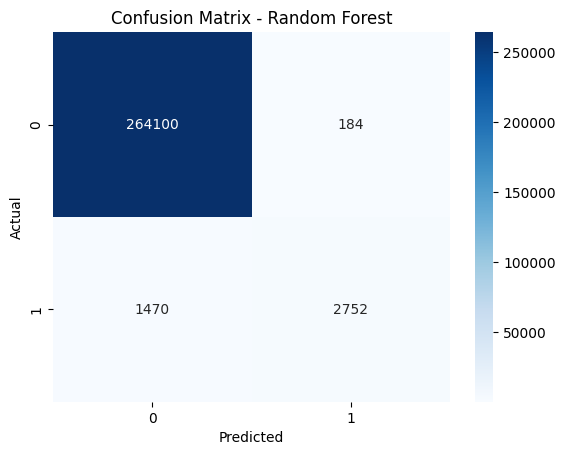

Classification Report:
              precision    recall  f1-score   support

           0      0.994     0.999     0.997    264284
           1      0.937     0.652     0.769      4222

    accuracy                          0.994    268506
   macro avg      0.966     0.826     0.883    268506
weighted avg      0.994     0.994     0.993    268506

ROC AUC: 0.9971


In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba[:, 1]):.4f}")

In [ ]:
# joblib.dump(model, 'Random_Forest.joblib')

['Random_Forest.joblib']

In [ ]:
# files.download('Random_Forest.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Although Random Forest is sometimes underrated compared to newer or more complex models, it often delivers strong performance, especially on structured (tabular) data. It’s robust to outliers, handles missing values well, and can capture non-linear relationships. In many real-world cases, Random Forest provides competitive results with far less tuning and complexity—making it both powerful and practical.

# Train Model - Random Forest with PCA

We compared model performance before and after applying PCA. Although PCA helped reduce the number of features and simplified the data, the model performed slightly worse after dimensionality reduction. This suggests that some of the removed features may still carry valuable information for predicting sepsis. Therefore, in this case, keeping all features—even with slightly higher complexity—results in better predictive performance.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_DR[df_DR.columns[~df_DR.columns.isin(['SepsisLabel'])]]
y = df_DR['SepsisLabel']

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
model2 = RandomForestClassifier(n_estimators=100, random_state=42)
model2.fit(X_train2, y_train2)

# loaded_model = joblib.load('Random_Forest_PCA.joblib')
# model2 = loaded_model

In [ ]:
y_pred2 = model2.predict(X_test2)
y_proba2 = model2.predict_proba(X_test2)[:, 1]
print("Confusion Matrix:")
cm = confusion_matrix(y_test2, y_pred2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print("Classification Report:")
print(classification_report(y_test2, y_pred2, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test2, y_proba2):.4f}")

[[264124    160]
 [  1779   2443]]
              precision    recall  f1-score   support

           0      0.993     0.999     0.996    264284
           1      0.939     0.579     0.716      4222

    accuracy                          0.993    268506
   macro avg      0.966     0.789     0.856    268506
weighted avg      0.992     0.993     0.992    268506

ROC AUC: 0.9960


Confusion Matrix:


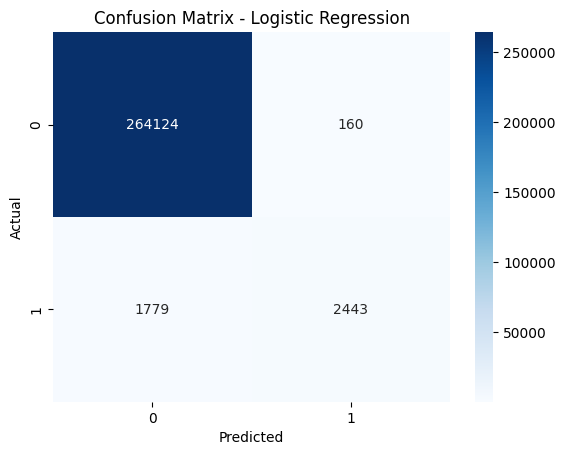

Classification Report:
              precision    recall  f1-score   support

           0      0.993     0.999     0.996    264284
           1      0.939     0.579     0.716      4222

    accuracy                          0.993    268506
   macro avg      0.966     0.789     0.856    268506
weighted avg      0.992     0.993     0.992    268506

ROC AUC: 0.9960


In [ ]:
y_pred2 = model2.predict(X_test2)
y_proba2 = model2.predict_proba(X_test2)[:, 1]
print("Confusion Matrix:")
cm = confusion_matrix(y_test2, y_pred2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print("Classification Report:")
print(classification_report(y_test2, y_pred2, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test2, y_proba2):.4f}")

In [ ]:
# joblib.dump(model2, 'Random_Forest_PCA.joblib')

['Random_Forest_PCA.joblib']

In [ ]:
# files.download('Random_Forest_PCA.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



# Train Model - Random Forest with SHAP Feature Selection



However, we can try one more feature selection (SHAP) method to support our point that the original features may be more valuable for the model. SHAP is useful because it selects features based on their actual contribution to the model’s predictions, offering a more model-specific and explainable approach to feature importance.

SHAP learns which features are important from the training data and checks how well they work on the test data. This helps prevent the model from overfitting and picking features that only work well on the training set.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_FS[df_FS.columns[~df_FS.columns.isin(['SepsisLabel'])]]
y = df_FS['SepsisLabel']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

> Because SHAP is computationally expensive, we are using random sampling 500 rows from the whole dataset.

In [ ]:
#Previous trained model (so u can focus on running SHAP)
# loaded_model = joblib.load('Random_Forest.joblib')
# model = loaded_model

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

In [ ]:
import shap
explainer = shap.TreeExplainer(model) # Please get the model (Train Model - Random Forest Without PCA and SHAP Feature Selection)

In [ ]:
X_sample = X_test.sample(n=500, random_state=42)

shap_values = explainer.shap_values(X_sample)

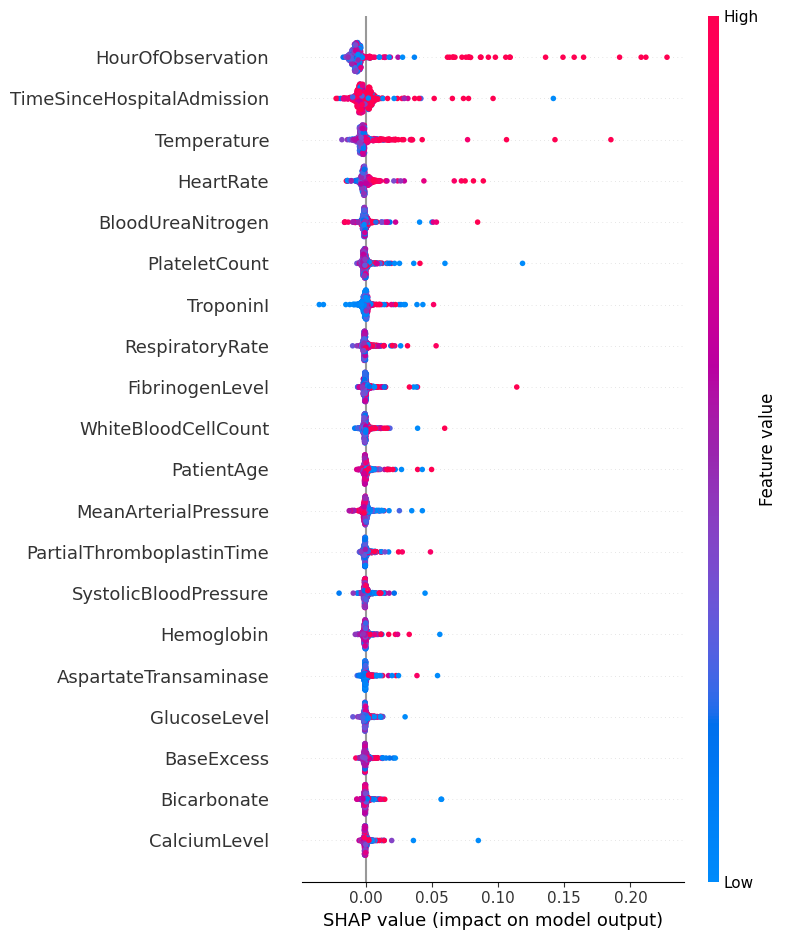

In [ ]:
shap_class1 = shap_values[:, :, 1]
shap.summary_plot(shap_class1, X_sample)

In [ ]:
mean_abs_shap = np.abs(shap_class1).mean(axis=0)
top_20_features = pd.Series(mean_abs_shap, index=X_sample.columns).sort_values(ascending=False).head(20)
all = pd.Series(mean_abs_shap, index=X_sample.columns).sort_values(ascending=False)

print("All Features:")
print(all)

print("\nTop 20 Features:")
print(top_20_features)

All Features:
HourOfObservation             0.012803
TimeSinceHospitalAdmission    0.005922
Temperature                   0.005629
HeartRate                     0.003736
BloodUreaNitrogen             0.002620
PlateletCount                 0.002441
TroponinI                     0.002322
RespiratoryRate               0.002125
FibrinogenLevel               0.002003
WhiteBloodCellCount           0.001889
PatientAge                    0.001871
MeanArterialPressure          0.001789
PartialThromboplastinTime     0.001738
SystolicBloodPressure         0.001675
Hemoglobin                    0.001636
AspartateTransaminase         0.001620
GlucoseLevel                  0.001618
BaseExcess                    0.001537
Bicarbonate                   0.001536
CalciumLevel                  0.001518
DiastolicBloodPressure        0.001499
CreatinineLevel               0.001445
ChlorideLevel                 0.001393
OxygenSaturationArterial      0.001384
PhosphateLevel                0.001383
AlkalinePho

In [ ]:
X_train_shap = X_train[top_20_features.index]
X_test_shap = X_test[top_20_features.index]

model.fit(X_train_shap, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = model.predict(X_test_shap)
y_proba = model.predict_proba(X_test_shap)[:, 1]
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

[[264135    149]
 [  1704   2518]]
              precision    recall  f1-score   support

           0      0.994     0.999     0.997    264284
           1      0.944     0.596     0.731      4222

    accuracy                          0.993    268506
   macro avg      0.969     0.798     0.864    268506
weighted avg      0.993     0.993     0.992    268506

ROC AUC: 0.9971


> The result is quite close to the normal model. Next, we’ll increase the SHAP sample size to 1000 to observe if it improves the explanation quality and model interpretation.

In [ ]:
X_sample2 = X_test.sample(n=1000, random_state=42)
shap_values2 = explainer.shap_values(X_sample2)

In [ ]:
shap_class1_2 = shap_values2[:, :, 1]

mean_abs_shap2 = np.abs(shap_class1_2).mean(axis=0)
top_20_features_2 = pd.Series(mean_abs_shap2, index=X_sample2.columns).sort_values(ascending=False).head(20)

In [ ]:
X_train_shap2 = X_train[top_20_features_2.index]
X_test_shap2 = X_test[top_20_features_2.index]

model.fit(X_train_shap2, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
print(top_20_features_2)

HourOfObservation             0.012838
TimeSinceHospitalAdmission    0.005763
Temperature                   0.005334
HeartRate                     0.003453
BloodUreaNitrogen             0.002484
TroponinI                     0.002214
PlateletCount                 0.002178
RespiratoryRate               0.001928
FibrinogenLevel               0.001813
WhiteBloodCellCount           0.001787
PatientAge                    0.001782
MeanArterialPressure          0.001743
Hemoglobin                    0.001697
AspartateTransaminase         0.001664
PartialThromboplastinTime     0.001602
DiastolicBloodPressure        0.001528
GlucoseLevel                  0.001514
BaseExcess                    0.001511
SystolicBloodPressure         0.001454
CreatinineLevel               0.001445
dtype: float64


In [ ]:
# top_20_2 = [
#     "HourOfObservation",
#     "TimeSinceHospitalAdmission",
#     "Temperature",
#     "HeartRate",
#     "BloodUreaNitrogen",
#     "TroponinI",
#     "PlateletCount",
#     "RespiratoryRate",
#     "FibrinogenLevel",
#     "WhiteBloodCellCount",
#     "PatientAge",
#     "MeanArterialPressure",
#     "Hemoglobin",
#     "AspartateTransaminase",
#     "PartialThromboplastinTime",
#     "DiastolicBloodPressure",
#     "GlucoseLevel",
#     "BaseExcess",
#     "SystolicBloodPressure",
#     "CreatinineLevel"
# ]

# X_test_shap2 = X_test[top_20_2]

# loaded_model = joblib.load('Random_Forest_SHAP_1000_Samples.joblib')
# model = loaded_model

Confusion Matrix:


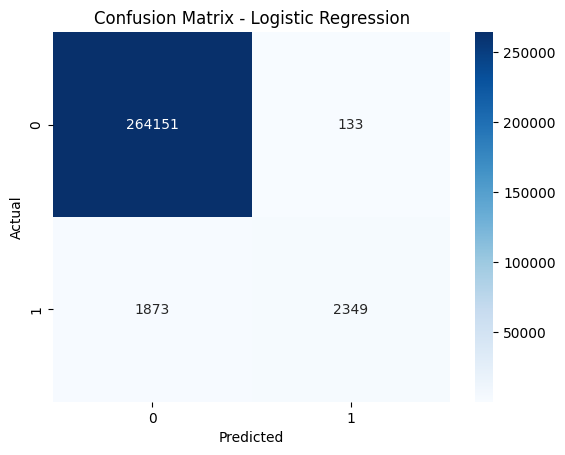

Classification Report:
              precision    recall  f1-score   support

           0      0.993     0.999     0.996    264284
           1      0.946     0.556     0.701      4222

    accuracy                          0.993    268506
   macro avg      0.970     0.778     0.848    268506
weighted avg      0.992     0.993     0.992    268506

ROC AUC: 0.9965


In [ ]:
y_pred = model.predict(X_test_shap2)
y_proba = model.predict_proba(X_test_shap2)[:, 1]
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

> With 1,000 samples, the SHAP visualization gives us a more complete view of the data. However, the model's performance slightly drops, indicating that each feature still contributes meaningful information to the prediction. This suggests that further feature selection may remove useful signals and should be avoided.

In [ ]:
# joblib.dump(model, 'Random_Forest_SHAP_1000_Samples.joblib')

['Random_Forest_SHAP_1000_Samples.joblib']

In [ ]:
# files.download('Random_Forest_SHAP_1000_Samples.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# (Experiment) Train Model - Random Forest with SMOTE

> One of the main reasons the model performs poorly is due to the imbalance in the dataset.

To address that, we could use SMOTE (Synthetic Minority Over-sampling Technique), which creates synthetic samples of the minority class to balance the dataset.

However, since the added data is synthetic, this training is considered experimental and should be interpreted with caution.

IMPORTANT: To avoid data leakage and ensure a fair evaluation of the model, SMOTE is applied only to the training set after the dataset is split. This approach is widely recommended in literature to prevent information from the test set from influencing the model training process.


(Based on: [Source Link](https://vch98.medium.com/preventing-data-leakage-standardscaler-and-smote-e7416c63259c))

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

smote = SMOTE(random_state=42)

X = df_FS[df_FS.columns[~df_FS.columns.isin(['SepsisLabel'])]]
y = df_FS['SepsisLabel']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# loaded_model = joblib.load('Random_Forest.joblib')
# model = loaded_model

In [ ]:
model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [ ]:
#Skip the train

# loaded_model = joblib.load('Random_Forest_With_SMOTE.joblib')
# model = loaded_model

In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print("Confusion Matrix:")
cm = confusion_matrix(y_test2, y_pred2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

[[263870    414]
 [   800   3422]]
              precision    recall  f1-score   support

           0      0.997     0.998     0.998    264284
           1      0.892     0.811     0.849      4222

    accuracy                          0.995    268506
   macro avg      0.945     0.904     0.924    268506
weighted avg      0.995     0.995     0.995    268506

ROC AUC: 0.9979


Confusion Matrix:


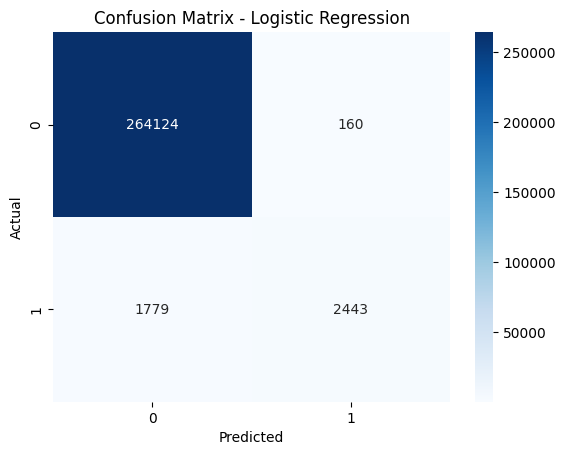

Classification Report:
              precision    recall  f1-score   support

           0      0.997     0.998     0.998    264284
           1      0.892     0.811     0.849      4222

    accuracy                          0.995    268506
   macro avg      0.945     0.904     0.924    268506
weighted avg      0.995     0.995     0.995    268506

ROC AUC: 0.9979


In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print("Confusion Matrix:")
cm = confusion_matrix(y_test2, y_pred2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

After training, the results improved compared to the previous model. While this model could be used, it's important to remain skeptical since the improvement might be influenced by synthetic data rather than real-world patterns.

In [ ]:
# joblib.dump(model, 'Random_Forest_With_SMOTE.joblib')

['Random_Forest_With_SMOTE.joblib']

In [ ]:
# files.download('Random_Forest_With_SMOTE.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train Comparison Model - SVM and (Experiment) Proving Assumption

> **Assumption**: Since our main model, Random Forest, performs better without PCA, we assume that the selected features (df_FS) still carry meaningful predictive value.

Therefore, for fair comparison, we will train other models using the feature-selected dataset (df_FS) without applying dimensionality reduction.

> However, to validate our assumption further, we will also experiment with SVM using PCA-reduced features. If the model performs worse with PCA, it strengthens our claim that the original features are important and shouldn't be discarded.

> Train with selected features

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_FS[df_FS.columns[~df_FS.columns.isin(['SepsisLabel'])]]
y = df_FS['SepsisLabel']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

> Support Vector Machines (SVM) are powerful models, but they become computationally expensive as the dataset grows. This is because SVM needs to calculate the relationship between every pair of data points, especially when using kernels like RBF.

> The training complexity can reach O(n²) to O(n³), where n is the number of samples. So, with 10,000 rows, it may process around 100 million combinations. But with 100,000 rows, it can explode to 10 billion, making it much slower or even impossible to run on normal machines.

> To avoid this, we reduce the training size through sampling (e.g., using 10k until 50k rows). This keeps the training manageable while still capturing key patterns in the data.

>First we start with 10k rows

In [ ]:
X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train,
    train_size=10000,
    stratify=y_train,
    random_state=42
)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_small)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf'],
    'class_weight': ['balanced']
}

grid = GridSearchCV(
    SVC(), param_grid,
    cv=3, scoring='f1',
    verbose=2, n_jobs=-1
)

grid.fit(X_train_scaled, y_train_small)

print("Best params:", grid.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


Confusion Matrix:


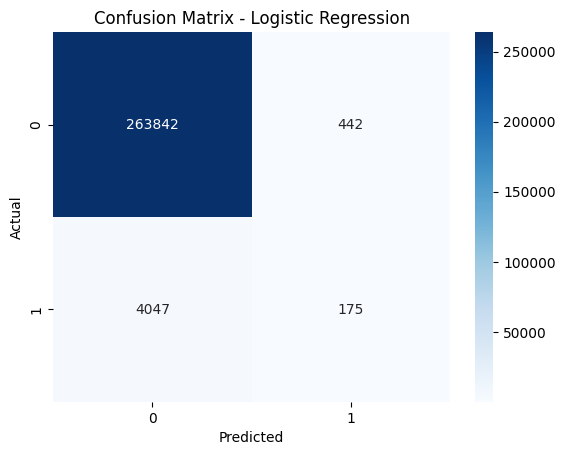

Classification Report:
              precision    recall  f1-score   support

           0      0.985     0.998     0.992    264284
           1      0.284     0.041     0.072      4222

    accuracy                          0.983    268506
   macro avg      0.634     0.520     0.532    268506
weighted avg      0.974     0.983     0.977    268506

ROC AUC: 0.6552


In [ ]:
model = grid.best_estimator_
y_pred = model.predict(X_test_scaled)
y_proba = model.decision_function(X_test_scaled)
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

Let's see if by increasing the sample size the model will perform better or not

In [ ]:
X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train,
    train_size=20000,
    stratify=y_train,
    random_state=42
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_small)
X_test_scaled = scaler.transform(X_test)

In [ ]:
grid.fit(X_train_scaled, y_train_small)

print("Best params:", grid.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


Confusion Matrix:


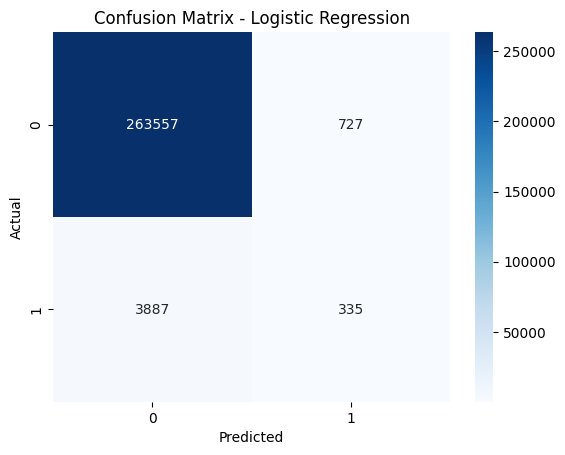

Classification Report:
              precision    recall  f1-score   support

           0      0.985     0.997     0.991    264284
           1      0.315     0.079     0.127      4222

    accuracy                          0.983    268506
   macro avg      0.650     0.538     0.559    268506
weighted avg      0.975     0.983     0.978    268506

ROC AUC: 0.6666


In [ ]:
model = grid.best_estimator_

# loaded_model = joblib.load('SVM.joblib')
# model = loaded_model

y_pred = model.predict(X_test_scaled)
y_proba = model.decision_function(X_test_scaled)
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

> Since the improvement in performance is small compared to the exponentially increasing computational cost, this model is not efficient for training. Hence, we would not continue it.

In [ ]:
# joblib.dump(model, 'SVM.joblib')

['SVM.joblib']

In [ ]:
# files.download('SVM.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

> (Experiment) Train with PCA (Dimensionality Reduction) set

This experiment aims to prove that each feature contributes its own predictive value.

In [ ]:
X_DR = df_DR[df_DR.columns[~df_DR.columns.isin(['SepsisLabel'])]]
y_DR = df_DR['SepsisLabel']

X_train, X_test, y_train, y_test = train_test_split(
    X_DR, y_DR,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train,
    train_size=20000,
    stratify=y_train,
    random_state=42
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_small)
X_test_scaled = scaler.transform(X_test)

In [ ]:
grid.fit(X_train_scaled, y_train_small)

print("Best params:", grid.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


Confusion Matrix:


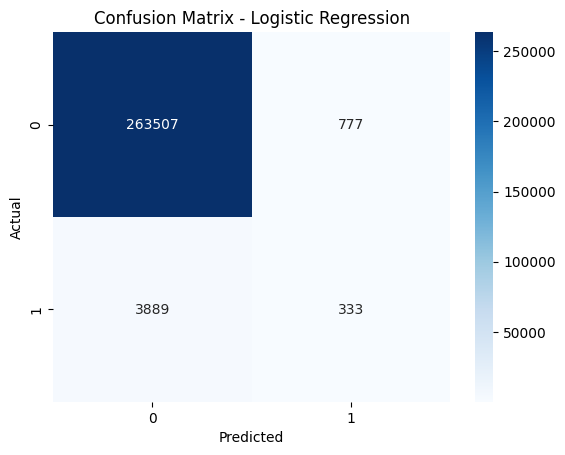

Classification Report:
              precision    recall  f1-score   support

           0      0.985     0.997     0.991    264284
           1      0.300     0.079     0.125      4222

    accuracy                          0.983    268506
   macro avg      0.643     0.538     0.558    268506
weighted avg      0.975     0.983     0.978    268506

ROC AUC: 0.6597


In [ ]:
model = grid.best_estimator_

# loaded_model = joblib.load('SVM_DR.joblib')
# model = loaded_model

y_pred = model.predict(X_test_scaled)
y_proba = model.decision_function(X_test_scaled)
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

> Result:

The results show a slightly lower performance compared to the original model, but we did gain some efficiency in computation. However, since the performance difference is minimal or even worse, we decided not to use PCA in the next model comparisons. In other words, our assumption that each feature has its own meaningful prediction value is valid.

In [ ]:
# joblib.dump(model, 'SVM_DR.joblib')

['SVM_DR.joblib']

In [ ]:
# files.download('SVM_DR.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train Comparison Model - Logistic Regression

We'll also do the same using another model which is Logistic Regression. Knowing that feature selection favors the performance. We'll stick to it and use the dataset after going through feature selection process to train the model, knowing that random forest didn't perform well after going through dimensionality reduction

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

X = df_FS[df_FS.columns[~df_FS.columns.isin(['SepsisLabel'])]]
y = df_FS['SepsisLabel']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')
logreg.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
# loaded_model = joblib.load('Logistic_Regression.joblib')
# logreg = loaded_model

Confusion Matrix:


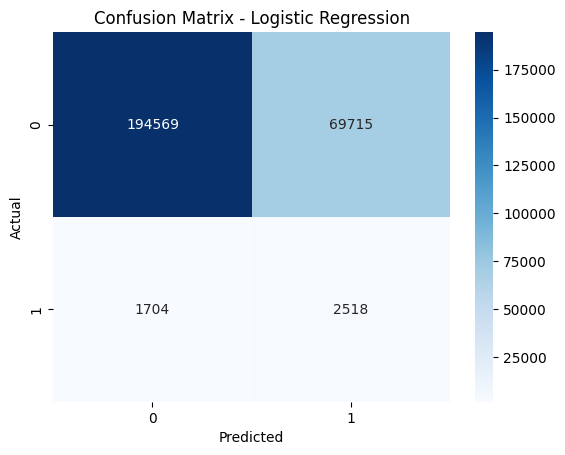

Classification Report:
              precision    recall  f1-score   support

           0      0.991     0.736     0.845    264284
           1      0.035     0.596     0.066      4222

    accuracy                          0.734    268506
   macro avg      0.513     0.666     0.455    268506
weighted avg      0.976     0.734     0.833    268506

ROC AUC: 0.7168


In [ ]:
y_proba = logreg.predict_proba(X_test)
y_pred = logreg.predict(X_test)

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba[:, 1]):.4f}")

We will increase the number of iterations to evaluate whether it yields any performance improvement.

In [ ]:
logreg = LogisticRegression(max_iter=10000, class_weight='balanced', solver='lbfgs')
logreg.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=10000)

Confusion Matrix:


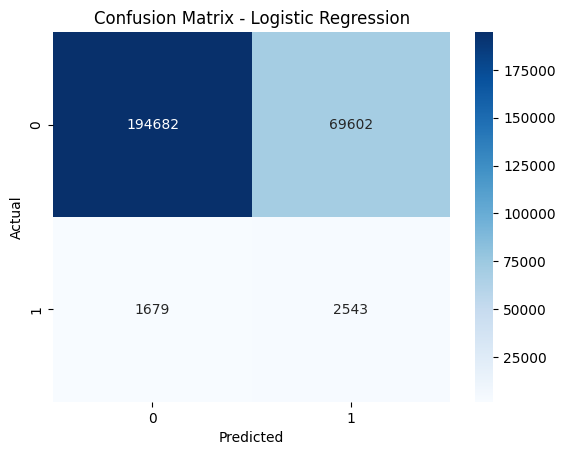

Classification Report:
              precision    recall  f1-score   support

           0      0.991     0.737     0.845    264284
           1      0.035     0.602     0.067      4222

    accuracy                          0.735    268506
   macro avg      0.513     0.669     0.456    268506
weighted avg      0.976     0.735     0.833    268506

ROC AUC: 0.7203


In [ ]:
y_proba = logreg.predict_proba(X_test)
y_pred = logreg.predict(X_test)

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba[:, 1]):.4f}")

After testing with a sample ten times larger, the performance improved very little, so training with this model isn’t worth it.

However, since this one model has larger iteration, we'll keep this one instead.

In [ ]:
# joblib.dump(logreg, 'Logistic_Regression.joblib')

['Logistic_Regression.joblib']

In [ ]:
# files.download('Logistic_Regression.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train Comparison Model - XGBoost



In this section, we train the XGBoost Classifier model to detect sepsis using selected clinical features. This model is known to be robust to tabular data and capable of providing rapid prediction results.

In [ ]:
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
# Memisahkan fitur dan target
X = df_FS.drop(columns=['SepsisLabel'])  # semua fitur
y = df_FS['SepsisLabel']  # label target (0 atau 1)

In [ ]:
from sklearn.model_selection import train_test_split

# Split utama: train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split data training untuk validasi (bukan data test ya)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_tr, y_tr)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:54:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# import joblib
# loaded_model = joblib.load('XGBoost.joblib')
# xgb_model = loaded_model

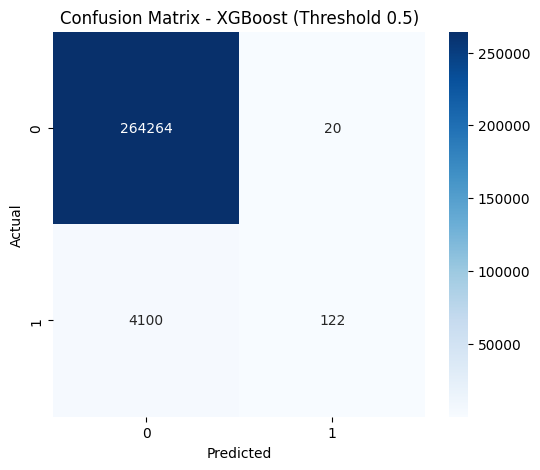

Evaluasi Awal XGBoost (threshold = 0.5)
              precision    recall  f1-score   support

  Non-Sepsis       0.98      1.00      0.99    264284
      Sepsis       0.86      0.03      0.06      4222

    accuracy                           0.98    268506
   macro avg       0.92      0.51      0.52    268506
weighted avg       0.98      0.98      0.98    268506



In [ ]:
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost (Threshold 0.5)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Evaluasi Awal XGBoost (threshold = 0.5)")
print(classification_report(y_test, y_pred_xgb, target_names=["Non-Sepsis", "Sepsis"]))

In [ ]:
auc = roc_auc_score(y_test, y_proba_xgb)
print(f"ROC AUC Score (XGBoost): {auc:.3f}")


ROC AUC Score (XGBoost): 0.909


<Figure size 1000x600 with 0 Axes>

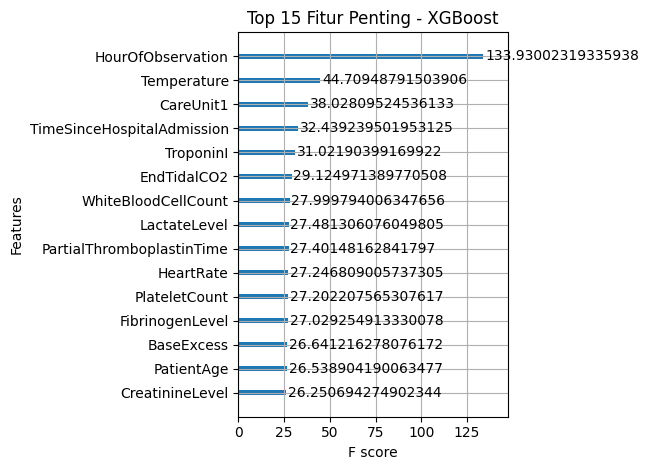

In [ ]:
plt.figure(figsize=(10,6))
plot_importance(xgb_model, max_num_features=15, importance_type='gain')
plt.title("Top 15 Fitur Penting - XGBoost")
plt.tight_layout()
plt.show()


> The evaluation results showed a very high overall accuracy (98%), but this was largely due to the model's ability to recognize the predominant number of non-sepsis patients. Meanwhile, the model's performance in detecting sepsis patients was still very low, with a recall of only around 3% and an f1-score of 0.05.

> This means the model failed to recognize a large proportion of sepsis patients, which could be dangerous in practice as it could miss high-risk patients.

> Although the ROC AUC value of 0.906 appears promising, this reflects the model's ability to distinguish between the two classes in general, rather than its actual performance on sepsis patients. Therefore, this model is not yet suitable for use in the context of critical clinical detection without significant improvements, particularly in addressing the existing class imbalance.

In this section, we train the XGBoost Classifier model to detect sepsis using selected clinical features. This model is known to be robust to tabular data and capable of providing rapid prediction results.

In [ ]:
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
# Memisahkan fitur dan target
X = df_FS.drop(columns=['SepsisLabel'])  # semua fitur
y = df_FS['SepsisLabel']  # label target (0 atau 1)

In [ ]:
from sklearn.model_selection import train_test_split

# Split utama: train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split data training untuk validasi (bukan data test ya)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_tr, y_tr)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:30:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# import joblib
# loaded_model = joblib.load('XGBoost.joblib')
# xgb_model = loaded_model

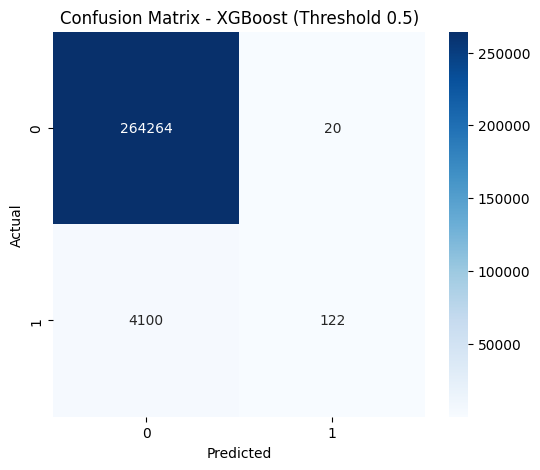

Evaluasi Awal XGBoost (threshold = 0.5)
              precision    recall  f1-score   support

  Non-Sepsis       0.98      1.00      0.99    264284
      Sepsis       0.86      0.03      0.06      4222

    accuracy                           0.98    268506
   macro avg       0.92      0.51      0.52    268506
weighted avg       0.98      0.98      0.98    268506



In [ ]:
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost (Threshold 0.5)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Evaluasi Awal XGBoost (threshold = 0.5)")
print(classification_report(y_test, y_pred_xgb, target_names=["Non-Sepsis", "Sepsis"]))

In [ ]:
auc = roc_auc_score(y_test, y_proba_xgb)
print(f"ROC AUC Score (XGBoost): {auc:.3f}")


ROC AUC Score (XGBoost): 0.909


<Figure size 1000x600 with 0 Axes>

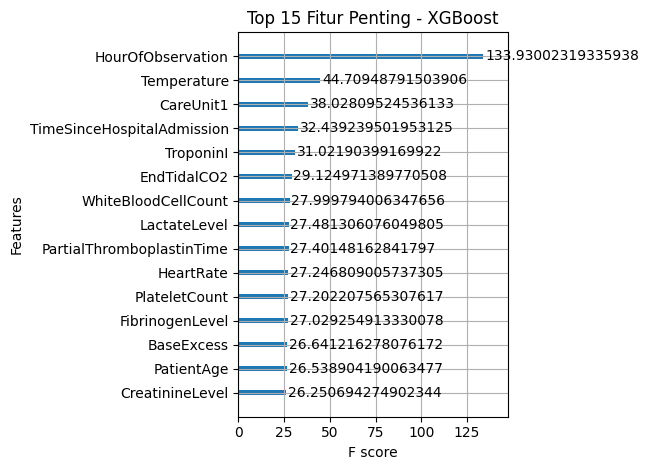

In [ ]:
plt.figure(figsize=(10,6))
plot_importance(xgb_model, max_num_features=15, importance_type='gain')
plt.title("Top 15 Fitur Penting - XGBoost")
plt.tight_layout()
plt.show()


> The evaluation results showed a very high overall accuracy (98%), but this was largely due to the model's ability to recognize the predominant number of non-sepsis patients. Meanwhile, the model's performance in detecting sepsis patients was still very low, with a recall of only around 3% and an f1-score of 0.05.

> This means the model failed to recognize a large proportion of sepsis patients, which could be dangerous in practice as it could miss high-risk patients.

> Although the ROC AUC value of 0.906 appears promising, this reflects the model's ability to distinguish between the two classes in general, rather than its actual performance on sepsis patients. Therefore, this model is not yet suitable for use in the context of critical clinical detection without significant improvements, particularly in addressing the existing class imbalance.

# Train Comparison Model - XGBoost (pos scale weight)

At this step, the XGBoost model was trained using a class weighting approach via the scale_pos_weight parameter. Instead of adding synthetic data like SMOTE, this approach mathematically penalizes misclassifications in the minority class (sepsis patients), thus encouraging the model to be more aware of sepsis cases without changing the data distribution.

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier


In [ ]:
# Memisahkan fitur dan target
X = df_FS.drop(columns=['SepsisLabel'])  # semua fitur
y = df_FS['SepsisLabel']  # label target (0 atau 1)

In [ ]:
from sklearn.model_selection import train_test_split

# Split utama: train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split data training untuk validasi (bukan data test ya)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [ ]:
# (Opsional jika belum ada) Buat X_train, y_train, X_test, y_test
# Misalnya setelah imputasi, scaling, drop ID, dsb.

print("Jumlah fitur:", X_train.shape[1])
print("Data train:", X_train.shape, "label:", y_train.shape)
print("Data test :", X_test.shape, "label:", y_test.shape)


Jumlah fitur: 38
Data train: (1074023, 38) label: (1074023,)
Data test : (268506, 38) label: (268506,)


In [ ]:
counter = Counter(y_train)
neg, pos = counter[0], counter[1]

scale_pos_weight = neg / pos
print(f"scale_pos_weight = {scale_pos_weight:.2f} (neg={neg}, pos={pos})")


scale_pos_weight = 62.60 (neg=1057135, pos=16888)


In [ ]:
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping

# Buat model
xgb_model_pos = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    use_label_encoder=False,
    verbosity=1,
    random_state=42
)

# Training model tanpa callbacks terlebih dahulu
xgb_model_pos.fit(
    X_tr,
    y_tr,
    eval_set=[(X_val, y_val)],
    verbose=True
)


[0]	validation_0-logloss:0.68111


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:31:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-logloss:0.66997
[2]	validation_0-logloss:0.65980
[3]	validation_0-logloss:0.65036
[4]	validation_0-logloss:0.64162
[5]	validation_0-logloss:0.63335
[6]	validation_0-logloss:0.62591
[7]	validation_0-logloss:0.61885
[8]	validation_0-logloss:0.61226
[9]	validation_0-logloss:0.60608
[10]	validation_0-logloss:0.60033
[11]	validation_0-logloss:0.59494
[12]	validation_0-logloss:0.58965
[13]	validation_0-logloss:0.58503
[14]	validation_0-logloss:0.58035
[15]	validation_0-logloss:0.57603
[16]	validation_0-logloss:0.57230
[17]	validation_0-logloss:0.56836
[18]	validation_0-logloss:0.56461
[19]	validation_0-logloss:0.56119
[20]	validation_0-logloss:0.55762
[21]	validation_0-logloss:0.55448
[22]	validation_0-logloss:0.55138
[23]	validation_0-logloss:0.54846
[24]	validation_0-logloss:0.54576
[25]	validation_0-logloss:0.54318
[26]	validation_0-logloss:0.54029
[27]	validation_0-logloss:0.53747
[28]	validation_0-logloss:0.53527
[29]	validation_0-logloss:0.53285
[30]	validation_0-loglo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# import joblib
# loaded_model = joblib.load('XGBoost_pos_scale_weight.joblib')
# xgb_model_pos = loaded_model

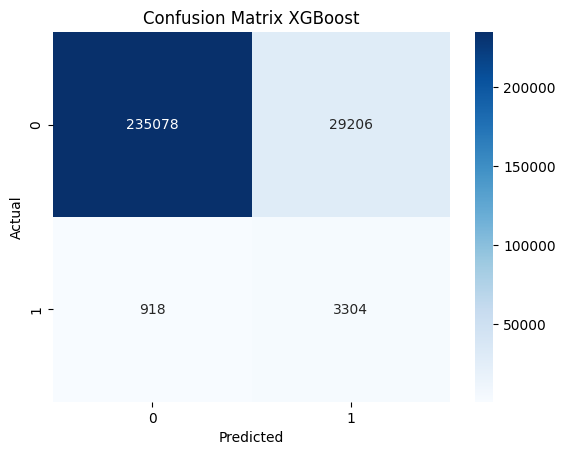

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    264284
           1       0.10      0.78      0.18      4222

    accuracy                           0.89    268506
   macro avg       0.55      0.84      0.56    268506
weighted avg       0.98      0.89      0.93    268506

AUC Score: 0.9210215635777199


In [ ]:
y_pred = xgb_model_pos.predict(X_test)
y_prob = xgb_model_pos.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix XGBoost")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))


> The results were quite promising: although the precision for sepsis remained low (0.10), the recall increased dramatically to 78%, indicating that the model was able to capture a significant proportion of sepsis patients. Although the overall accuracy decreased to 89% (from 98% previously), this is a reasonable trade-off in clinical diagnosis because missing sepsis patients is riskier than missing non-sepsis patients.

> The ROC AUC score of 0.921 confirmed that the model is quite good at distinguishing between the two classes. This approach is well suited for real-world medical scenarios that demand high sensitivity to critical cases like sepsis.

# Train Comparison Model - XGBoost smote

At this stage, the XGBoost model was trained using the SMOTE (Synthetic Minority Over-sampling Technique) technique to address the imbalance in data between sepsis and non-sepsis patients. SMOTE helps create synthetic data for the minority class (sepsis), allowing the model to achieve a more balanced distribution during learning.

In [ ]:
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
# Memisahkan fitur dan target
X = df_FS.drop(columns=['SepsisLabel'])  # semua fitur
y = df_FS['SepsisLabel']  # label target (0 atau 1)

In [ ]:
from sklearn.model_selection import train_test_split

# Split utama: train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split data training untuk validasi (bukan data test ya)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [ ]:
# Perbaikan tanpa n_jobs
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_tr_sm, y_tr_sm = smote.fit_resample(X_tr, y_tr)

print(f" Distribusi kelas setelah SMOTE: {Counter(y_tr_sm)}")


 Distribusi kelas setelah SMOTE: Counter({0: 845708, 1: 845708})


In [ ]:
xgb_smote = XGBClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Fit tanpa early stopping
xgb_smote.fit(X_tr_sm, y_tr_sm)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:32:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# import joblib
# loaded_model = joblib.load('XGBoost_smote.joblib')
# xgb_smote = loaded_model

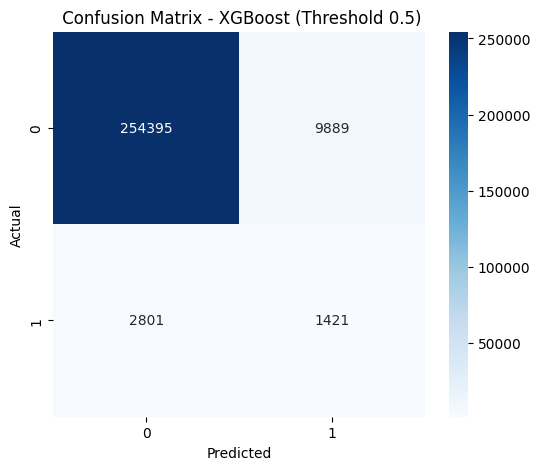

Evaluasi Awal XGBoost (threshold = 0.5)
              precision    recall  f1-score   support

  Non-Sepsis       0.99      0.96      0.98    264284
      Sepsis       0.13      0.34      0.18      4222

    accuracy                           0.95    268506
   macro avg       0.56      0.65      0.58    268506
weighted avg       0.98      0.95      0.96    268506



In [ ]:
y_proba_xgb = xgb_smote.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(" Confusion Matrix - XGBoost (Threshold 0.5)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Evaluasi Awal XGBoost (threshold = 0.5)")
print(classification_report(y_test, y_pred_xgb, target_names=["Non-Sepsis", "Sepsis"]))


In [ ]:
auc = roc_auc_score(y_test, y_proba_xgb)
print(f" ROC AUC Score (XGBoost): {auc:.3f}")


 ROC AUC Score (XGBoost): 0.827


<Figure size 1000x600 with 0 Axes>

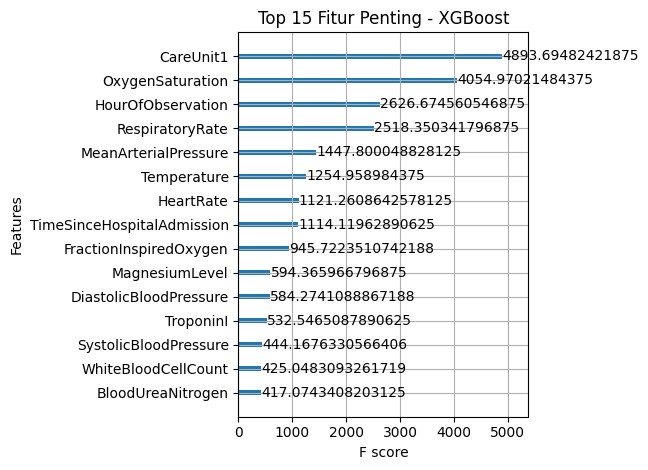

In [ ]:
plt.figure(figsize=(10,6))
plot_importance(xgb_smote, max_num_features=15, importance_type='gain')
plt.title("Top 15 Fitur Penting - XGBoost")
plt.tight_layout()
plt.show()


> The model was then trained with 500 trees and various regularization settings to avoid overfitting. The evaluation results showed a significant improvement in the model's ability to recognize sepsis patients, particularly in the recall of the sepsis class, which reached 34% (compared to the previous 1%).

> Although the precision is still low (13%) and the f1-score for sepsis remains weak (0.18), this is an important step towards more sensitive detection. The overall accuracy score of 95% and the ROC AUC of 0.827 are promising, but not yet ideal for critical medical decisions.

> Additional strategies such as prediction threshold tuning, error cost weighting, or anomaly detection are needed to improve the model's performance in detecting sepsis cases more accurately.

# Train Comparison Model - TabNet

We'll also do the same using another model which is TabNet. Knowing that feature selection favors the performance. We'll stick to it and use the dataset after going through feature selection process to train the model, knowing that random forest didn't perform well after going through dimensionality reduction

In [ ]:
pip install pytorch-tabnet

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier

X = df_FS.drop('SepsisLabel', axis=1).values
y = df_FS['SepsisLabel'].values

In [ ]:
# 1. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [ ]:
# 2. Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
# 3. Train TabNet
clf = TabNetClassifier()

clf.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_name=['valid'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.08365 | valid_accuracy: 0.98449 |  0:01:11s
epoch 1  | loss: 0.07678 | valid_accuracy: 0.98449 |  0:02:07s
epoch 2  | loss: 0.07401 | valid_accuracy: 0.98449 |  0:03:04s
epoch 3  | loss: 0.07338 | valid_accuracy: 0.98449 |  0:03:58s
epoch 4  | loss: 0.07285 | valid_accuracy: 0.98449 |  0:04:55s
epoch 5  | loss: 0.07258 | valid_accuracy: 0.98449 |  0:05:49s
epoch 6  | loss: 0.072   | valid_accuracy: 0.98449 |  0:06:46s
epoch 7  | loss: 0.07164 | valid_accuracy: 0.98449 |  0:07:40s
epoch 8  | loss: 0.07149 | valid_accuracy: 0.98449 |  0:08:36s
epoch 9  | loss: 0.07093 | valid_accuracy: 0.98449 |  0:09:35s
epoch 10 | loss: 0.07043 | valid_accuracy: 0.98449 |  0:10:30s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_valid_accuracy = 0.98449


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
# loaded_model = joblib.load('TabNet.joblib')
# clf = loaded_model

In [ ]:
#4. Predict

y_proba = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

Confusion Matrix:


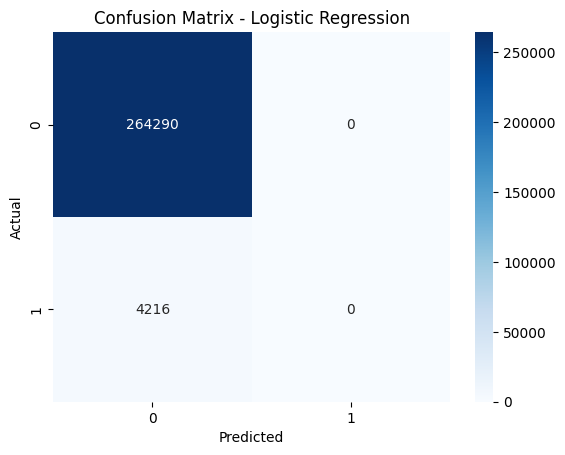

Classification Report:
              precision    recall  f1-score   support

           0      0.984     1.000     0.992    264290
           1      0.000     0.000     0.000      4216

    accuracy                          0.984    268506
   macro avg      0.492     0.500     0.496    268506
weighted avg      0.969     0.984     0.977    268506

ROC AUC: 0.6284


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 5. Evaluate
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba[:, 1]):.4f}")

We can see that after 10 epochs, the accuracy doesn't raise even once. The Tabnet model managed to predict non - sepsis label almost everytime. Unfortunately, it fails completely on predicting the sepsis label


# Train Comparison Model - EBM


The last one is the Explainer Boosting Model, known for its robustness.

In [ ]:
pip install interpret

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

X = df_FS.drop('SepsisLabel', axis=1).values
y = df_FS['SepsisLabel'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

ebm = ExplainableBoostingClassifier(
    interactions=0,
    max_bins=32,
    learning_rate=0.1,
    early_stopping_rounds=5,
    max_rounds=30,
    n_jobs=-1,
    random_state=42
)
ebm.fit(X_train, y_train)

# loaded_model = joblib.load('EBM.joblib')
# ebm = loaded_model

y_pred = ebm.predict(X_test)
y_proba = ebm.predict_proba(X_test)

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print("Classification Report:")print(classification_report(y_test, y_pred, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba[:, 1]):.4f}")

[[264284      0]
 [  4222      0]]
              precision    recall  f1-score   support

           0      0.984     1.000     0.992    264284
           1      0.000     0.000     0.000      4222

    accuracy                          0.984    268506
   macro avg      0.492     0.500     0.496    268506
weighted avg      0.969     0.984     0.976    268506

ROC AUC: 0.7629


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Train Comparison Model - ResNet1D

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

In [ ]:
# Pastikan df_FS sudah tersedia dan sudah dibersihkan sebelumnya
X = df_FS.drop('SepsisLabel', axis=1).values
y = df_FS['SepsisLabel'].values

# 1. Split Train & Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. Split Train -> Train + Validasi
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# 3. Scaling fitur
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
# 🔹 Blok residual 1D
class ResBlock1D(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size, downsample, use_do):
        super(ResBlock1D, self).__init__()

        self.use_do = use_do
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv1d(in_filters, out_filters, kernel_size=kernel_size,
                               stride=stride, padding=kernel_size // 2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_filters)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv1d(out_filters, out_filters, kernel_size=kernel_size,
                               stride=1, padding=kernel_size // 2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_filters)

        self.downsample_layer = None
        if downsample or in_filters != out_filters:
            self.downsample_layer = nn.Conv1d(in_filters, out_filters, kernel_size=1,
                                              stride=stride, bias=False)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample_layer is not None:
            identity = self.downsample_layer(identity)

        # Penyesuaian dimensi jika tidak match
        if out.shape[-1] != identity.shape[-1]:
            identity = F.interpolate(identity, size=out.shape[-1], mode='nearest')

        out = out + identity  # <- FIXED: avoid in-place
        out = F.relu(out)

        if self.use_do:
            out = self.dropout(out)

        return out


# Arsitektur ResNet1D
class ResNet1D(nn.Module):
    def __init__(self, in_channels, base_filters, kernel_size, stride, groups,
                 n_block, n_classes, downsample_gap, increasefilter_gap, use_do=True):
        super(ResNet1D, self).__init__()
        self.use_do = use_do
        self.n_block = n_block
        self.downsample_gap = downsample_gap
        self.increasefilter_gap = increasefilter_gap

        self.firstconv = nn.Conv1d(in_channels, base_filters, kernel_size=kernel_size,
                                   stride=stride, padding=kernel_size // 2, bias=False)
        self.firstbn = nn.BatchNorm1d(base_filters)
        self.firstrelu = nn.ReLU()

        filters = base_filters
        in_filters = base_filters
        self.blocks = nn.ModuleList()

        for block_idx in range(n_block):
            downsample = (block_idx % downsample_gap == 0)
            increase_filters = (block_idx % increasefilter_gap == 0 and block_idx != 0)
            out_filters = filters * 2 if increase_filters else filters

            self.blocks.append(ResBlock1D(in_filters, out_filters, kernel_size, downsample, self.use_do))

            in_filters = out_filters
            filters = out_filters

        self.final_bn = nn.BatchNorm1d(filters)
        self.final_relu = nn.ReLU(inplace=True)
        self.final_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(filters, n_classes)

    def forward(self, x):
        x = self.firstrelu(self.firstbn(self.firstconv(x)))
        for block in self.blocks:
            x = block(x)
        x = self.final_relu(self.final_bn(x))
        x = self.final_pool(x).squeeze(-1)
        return self.fc(x)


In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # [N, 1, F]
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32).unsqueeze(1)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Deteksi GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Menggunakan device: {device}")

# Buat model baru
model = ResNet1D(
    in_channels=1,
    base_filters=64,
    kernel_size=8,
    stride=1,
    groups=1,
    n_block=2,
    n_classes=2,
    downsample_gap=2,
    increasefilter_gap=4,
    use_do=True
).to(device)

# Siapkan optimizer dan loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


 Menggunakan device: cuda


In [ ]:
from tqdm import tqdm

# Training config
num_epochs = 20  # boleh diubah, disarankan 20–50 untuk CNN
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0

    # Progress bar
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for xb, yb in loop:
        xb, yb = xb.to(device), yb.to(device)

        # Forward pass
        preds = model(xb)
        loss = criterion(preds, yb)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        _, predicted = preds.max(1)
        correct += predicted.eq(yb).sum().item()
        total += yb.size(0)

        # Update progress bar
        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    avg_loss = total_loss / len(train_loader)
    acc = 100. * correct / total
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Accuracy: {acc:.2f}%")


Epoch 1/20 | Loss: 0.0740 | Accuracy: 98.41%


Epoch 2/20 | Loss: 0.0715 | Accuracy: 98.42%


Epoch 3/20 | Loss: 0.0702 | Accuracy: 98.42%


Epoch 4/20 | Loss: 0.0682 | Accuracy: 98.42%


Epoch 5/20 | Loss: 0.0653 | Accuracy: 98.42%


Epoch 6/20 | Loss: 0.0622 | Accuracy: 98.43%


Epoch 7/20 | Loss: 0.0587 | Accuracy: 98.43%


Epoch 8/20 | Loss: 0.0553 | Accuracy: 98.45%


Epoch 9/20 | Loss: 0.0523 | Accuracy: 98.48%


Epoch 10/20 | Loss: 0.0501 | Accuracy: 98.49%


Epoch 11/20 | Loss: 0.0477 | Accuracy: 98.51%


Epoch 12/20 | Loss: 0.0459 | Accuracy: 98.55%


Epoch 13/20 | Loss: 0.0445 | Accuracy: 98.56%


Epoch 14/20 | Loss: 0.0429 | Accuracy: 98.60%


Epoch 15/20 | Loss: 0.0417 | Accuracy: 98.61%


Epoch 16/20 | Loss: 0.0407 | Accuracy: 98.64%


Epoch 17/20 | Loss: 0.0393 | Accuracy: 98.65%


Epoch 18/20 | Loss: 0.0383 | Accuracy: 98.67%


Epoch 19/20 | Loss: 0.0377 | Accuracy: 98.67%


Epoch 20/20 | Loss: 0.0366 | Accuracy: 98.71%


In [ ]:
# loaded_model = joblib.load('ResNet1D.joblib')
# model = loaded_model

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for xb, yb in valid_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        _, predicted = preds.max(1)
        correct += predicted.eq(yb).sum().item()
        total += yb.size(0)

val_acc = 100. * correct / total
print(f"Validation Accuracy ResNet1D: {val_acc:.2f}%")


Validation Accuracy ResNet1D: 98.71%


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()
y_true_list = []
y_pred_list = []
y_proba_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        proba = torch.softmax(logits, dim=1)
        pred = torch.argmax(proba, dim=1)

        y_true_list.append(y_batch.cpu())
        y_pred_list.append(pred.cpu())
        y_proba_list.append(proba.cpu())

y_true = torch.cat(y_true_list).numpy()
y_pred = torch.cat(y_pred_list).numpy()
y_proba = torch.cat(y_proba_list, dim=0)[:, 1].numpy()

In [ ]:
print("logits.shape:", logits.shape)
print("proba.shape:", proba.shape)
print("pred.shape:", pred.shape)
print("y_batch.shape:", y_batch.shape)

logits.shape: torch.Size([26, 2])
proba.shape: torch.Size([26, 2])
pred.shape: torch.Size([26])
y_batch.shape: torch.Size([26])


Confusion Matrix:


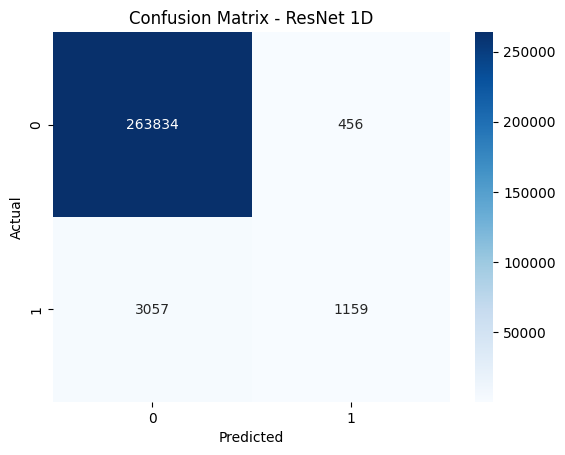


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    264290
           1       0.72      0.27      0.40      4216

    accuracy                           0.99    268506
   macro avg       0.85      0.64      0.70    268506
weighted avg       0.98      0.99      0.98    268506

ROC AUC: 0.9749075406680159


In [ ]:
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ResNet 1D")
plt.show()

print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("ROC AUC:", roc_auc_score(y_true, y_proba))

We can see that Resnet 1D may have a potential, but still the model didn't manage to catch up with Ran

In [ ]:
# joblib.dump(model, 'ResNet1D.joblib')

['ResNet1D.joblib']

In [ ]:
# files.download('ResNet1D.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusion


After comparing 6 models with the Random Forest model using dataset after correlation feature selection, we found out that none of the models manage to surpass the Random Forest model. Even though some model might have a potential like Resnet 1D, Random Forest has an excellent speed that's definitely useful for hospital that requires fast paced actions.